In [1]:
import argparse
import numpy as np
import pandas as pd
import itertools
import os
import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import roc_auc_score
import gc
import time
import re
import recordlinkage
from sklearn.model_selection import train_test_split

gc.collect()

0

### Read raw data outputs from the Luigi pipeline

In [2]:
# file0 = 'data/intermediate/wikidata/collectors.csv'  ## Windows file location, wikipedia collector
file0 = '~/Documents/nhm_coding/pkbdata_2024/wiki-collectors.csv'  ## macOS file location, wikipedia collector

wiki_data = pd.read_csv(file0,chunksize=10000,encoding='utf-8',on_bad_lines='skip',engine='python')
wiki_data = pd.concat(wiki_data)
wiki_columns = wiki_data.columns.tolist()   ## load content into list
wiki_data.head()

,qid,name,aliases,birthName,dateOfBirth,dateOfDeath,VIAF,authorAbbrv,harvardIndex,bionomia,IPNI,ISNI,employers,countriesOfCitizenship,employerCountries,sexOrGender
0,Q100142069,Frida Eggens,['Eggens'],NaN,NaN,NaN,NaN,Eggens,NaN,NaN,20045232-1,NaN,NaN,['SE'],NaN,female
1,Q100146795,Elizabeth Harrison,"['Mrs Arnold Harrison', 'Mrs A. H.']",NaN,+1792-12-00T00:00:00Z,+1834-01-05T00:00:00Z,NaN,NaN,NaN,Q100146795,NaN,NaN,NaN,"[None, None]",NaN,female
2,Q100149196,Russell Cox,[],NaN,NaN,NaN,NaN,NaN,NaN,0000-0001-5149-1709,NaN,NaN,['Q769416'],NaN,{'AU'},NaN
3,Q100152296,Alda Pereira da Fonseca,[],NaN,+1882-00-00T00:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[None],NaN,female
4,Q100156193,Laurence Henry Millener,"['L. H. Millener', 'Laurie Henry Millener', 'L...",NaN,+1914-04-01T00:00:00Z,+2000-00-00T00:00:00Z,NaN,NaN,NaN,Q100156193,NaN,NaN,['Q492467'],['NZ'],{'NZ'},male


In [3]:
# file1 = 'data/intermediate/harvard-index/collectors.csv'  ## Windows file location, harvard collector
file1 = '~/Documents/nhm_coding/pkbdata_2024/harvard-collectors.csv'  ## macOS file location, harvard collector

harvard_data = pd.read_csv(file1,chunksize=10000,encoding='utf-8',on_bad_lines='skip',engine='python')
harvard_data = pd.concat(harvard_data)
harvard_columns = harvard_data.columns.tolist()
# harvard_data.rename(columns={harvard_columns[8]:'labelName'}, inplace=True) ## to avoid special character in colNames

harvard_columns = harvard_data.columns.tolist()   ## load content into list
harvard_data.head()

,ASA Botanist ID,Author Teams:,Author name,B & P Author Abbrev.,Citation as Author,Citation as Collector,Collections in,Collector Teams:,Full Name,GUID,...,deathYear,deathYearIsApprox,geographyCombined,geographyISO,title,firstName,middleName,lastName,herbariaCode,institutionUUID
0,127603 botanist,"L. T. Lu & BrachChandani Gupta, S. S. Dash & A...",Brach,Brach,Novon 12(4): 495. 2002,pers. comm.,"1977 (34),2012 (1),2015 (51),2016 (13),2017 (2...",L. T. Lu & BrachA. R. Brach & J. M. BrachA. R....,"Brach, Anthony Robert",http://purl.oclc.org/net/edu.harvard.huh/guid/...,...,NaN,NaN,United States of America|United States of America,['US'],NaN,Anthony,Robert,Brach,{'SYRF'},[]
1,114612 botanist,W. R. Buck & B. C. TanNoguchi & B. C. TanB. C....,B. C. Tan,B.C.Tan,['Authors of Plant Names. Royal Botanic Garden...,"['Index Herbariorum - Collectors T-Z', 'Collec...","[no date] (3),1974 (1),1975 (2),1977 (1),1984 ...","B. C. Tan, E. A. Brown & R. G. CovenyB. C. Tan...","Tan, Benito Ching",http://purl.oclc.org/net/edu.harvard.huh/guid/...,...,2016.0,False,"Philippines, Singapore, United States of Ame...","['PH', 'SG', 'CN', 'MY', 'US', 'ID']",NaN,Benito,Ching,Tan,"{'UBC', 'H', 'SINU', 'B', 'FH'}","['5d6c8b57-9bfb-46e8-960f-f57343ca9729', '4cf9..."
2,125914 botanist,Ormerod & E.W.Wood,E. W. Wood,E.W.Wood,NaN,Index Herbariorum - Collectors T-Z,"1974 (2),1976 (1),1979 (6),1980 (1),1982 (5),1...","D. E. Boufford & E. W. WoodD. E. Boufford, V. ...","Wood, Emily Walker",http://purl.oclc.org/net/edu.harvard.huh/guid/...,...,NaN,NaN,United States of America|Japan,"['US', 'JP']",NaN,Emily,Walker,Wood,"{'TI', 'NCU', 'KYO', 'PE', 'CM', 'MO', 'A', 'C...","['ac8eb8fc-0703-4408-8388-686764b75877', 'ea90..."
3,144144 botanist,Garay & W. KittredgeP. T. Li & W. Kittredge,W. Kittredge,W. Kittr.,['Authors of Plant Names. Royal Botanic Garden...,"Index Herbariorum, ed. 8","[no date] (6),1973 (1),1974 (18),1975 (8),1981...",Garay & W. KittredgeP. T. Li & W. KittredgeW. ...,"Kittredge, Walter Tobey",http://purl.oclc.org/net/edu.harvard.huh/guid/...,...,NaN,NaN,United States of America|United States of America,['US'],NaN,Walter,Tobey,Kittredge,"{'NEBC', 'GH', 'AMES'}","['648a5b5f-0421-44fd-8dd3-82add535bc54', 'd56b..."
4,126030 botanist,NaN,NaN,NaN,NaN,"Index Herbariorum, ed. 8",NaN,"M. A. Sherwood, D. T. Plas, D. Gregory & G. A....","Cacavio, Gennaro J.",http://purl.oclc.org/net/edu.harvard.huh/guid/...,...,NaN,NaN,United States of America,['US'],NaN,Gennaro,J.,Cacavio,{'GH'},['648a5b5f-0421-44fd-8dd3-82add535bc54']


In [4]:
# file2 = 'data/intermediate/bionomia/collectors.parquet'  ## Windows file location, bionomia collector
file2 = '~/Documents/nhm_coding/pkbdata_2024/bionomia-collectors.parquet'  ## macOS file location, bionomia collector

bionomia_data = pd.read_parquet(file2)

bionomia_columns = bionomia_data.columns.tolist()   ## load content into list
bionomia_data.head()

,index,id,score,orcid,wikidata,uri,fullname,fullname_reverse,given,family,label,other_names,thumbnail,lifespan,description,is_public,has_occurrences,orgs,countries
0,0,88053,20.465666,None,Q108887181,http://www.wikidata.org/entity/Q108887181,A. R. Christiaensen,"Christiaensen, A. R.",A. R.,Christiaensen,A. R. Christiaensen,[A. Christiaensen],None,? &ndash; 1966,"mammalogist, scientific and botanical collector",True,True,None,None
1,1,2778,4.789909,0000-0001-7348-143X,None,https://orcid.org/0000-0001-7348-143X,Fabian A. Michelangeli,"Michelangeli, Fabian A.",Fabian A.,Michelangeli,None,"[F. A. Michelangeli, Fabian A. Michelangeli, F...",https://img.bionomia.net/?src=https%3A%2F%2Fbi...,None,,True,True,Q636275,US
2,2,122362,4.452014,None,Q113612396,http://www.wikidata.org/entity/Q113612396,J. G. A. Salmin,"Salmin, J. G. A.",J. G. A.,Salmin,J. G. A. Salmin,"[J.G.A. Salmin, Salmin]",None,? &ndash; ?,German dealer of naturalia in Hamburg,True,True,None,None
3,3,68322,4.775816,0000-0001-5980-1417,None,https://orcid.org/0000-0001-5980-1417,Jairo A. Moreno-González,"Moreno-González, Jairo A.",Jairo A.,Moreno-González,None,[],https://img.bionomia.net/?src=https%3A%2F%2Fbi...,None,I am a Ph.D. biologist interested in the taxon...,True,True,None,None
4,4,124267,5.383736,None,Q130018104,http://www.wikidata.org/entity/Q130018104,A.C. Persaud,"Persaud, A.C.",A.C.,Persaud,A.C. Persaud,[],None,? &ndash; 1925,Botanist and botanical collector (? - 1925),True,True,None,None


### Data: Attribute counts visualisation

In [5]:
# Method to compute and plot the data distribution of a given dataframe
def get_distribution(data, col):
    sum_count = 0
    data_distribution = {} ## a dictionary to store the distribution of individual entity
    data_distribution_sum = pd.DataFrame(columns = col, index=['sum'])
    for (columnName, columnData) in data.items():
        temp = data[columnName].value_counts()
        data_distribution_sum.at['sum', columnName]=sum(temp)
    return data_distribution_sum

                          sum
qid                     76927
aliases                 76927
name                    76636
sexOrGender             59151
authorAbbrv             54359
IPNI                    54294
dateOfBirth             42524
harvardIndex            38721
dateOfDeath             30283
countriesOfCitizenship  29067
VIAF                    26679
ISNI                    20015
bionomia                15055
employers               13550
employerCountries       13550
birthName                1346


<Axes: title={'center': 'WikiData'}>

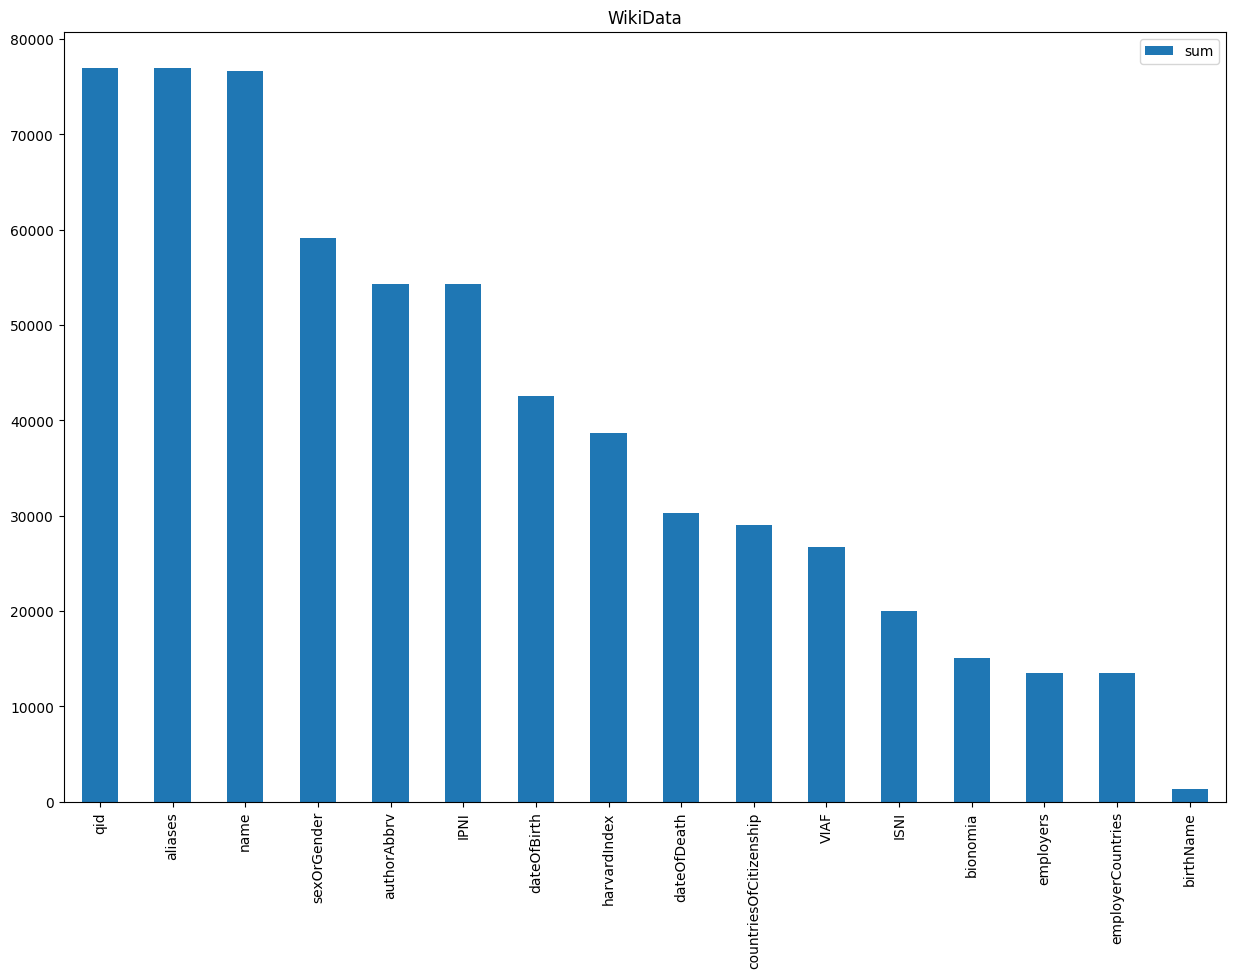

In [6]:
distribution = get_distribution(wiki_data, wiki_columns)
temp = distribution.T.sort_values(by=['sum'], ascending=False)
print(temp)
temp.plot.bar(figsize=(15,10), title = 'WikiData')

                          sum
ASA Botanist ID         76391
Name                    76391
id                      76391
asa_category            76391
GUID                    76373
Full Name               76358
Standard/Label Name     76351
firstName               76182
lastName                72284
Remarks                 60162
geographyISO            52982
geographyCombined       52982
Citation as Collector   50861
herbariaCode            45792
institutionUUID         45792
Geography Collector     42424
middleName              37842
Author name             36095
Specialty Author        35872
B & P Author Abbrev.    35822
Citation as Author      35616
Date of birth           33020
birthYearIsApprox       33020
birthYear               33020
Geography Author        18881
Specialty Collector     17896
deathYearIsApprox       17479
deathYear               17479
Date of death           17479
Collections in          16154
Holdings                16154
Collector Teams:        14910
First date

<Axes: title={'center': 'Harvard Index'}>

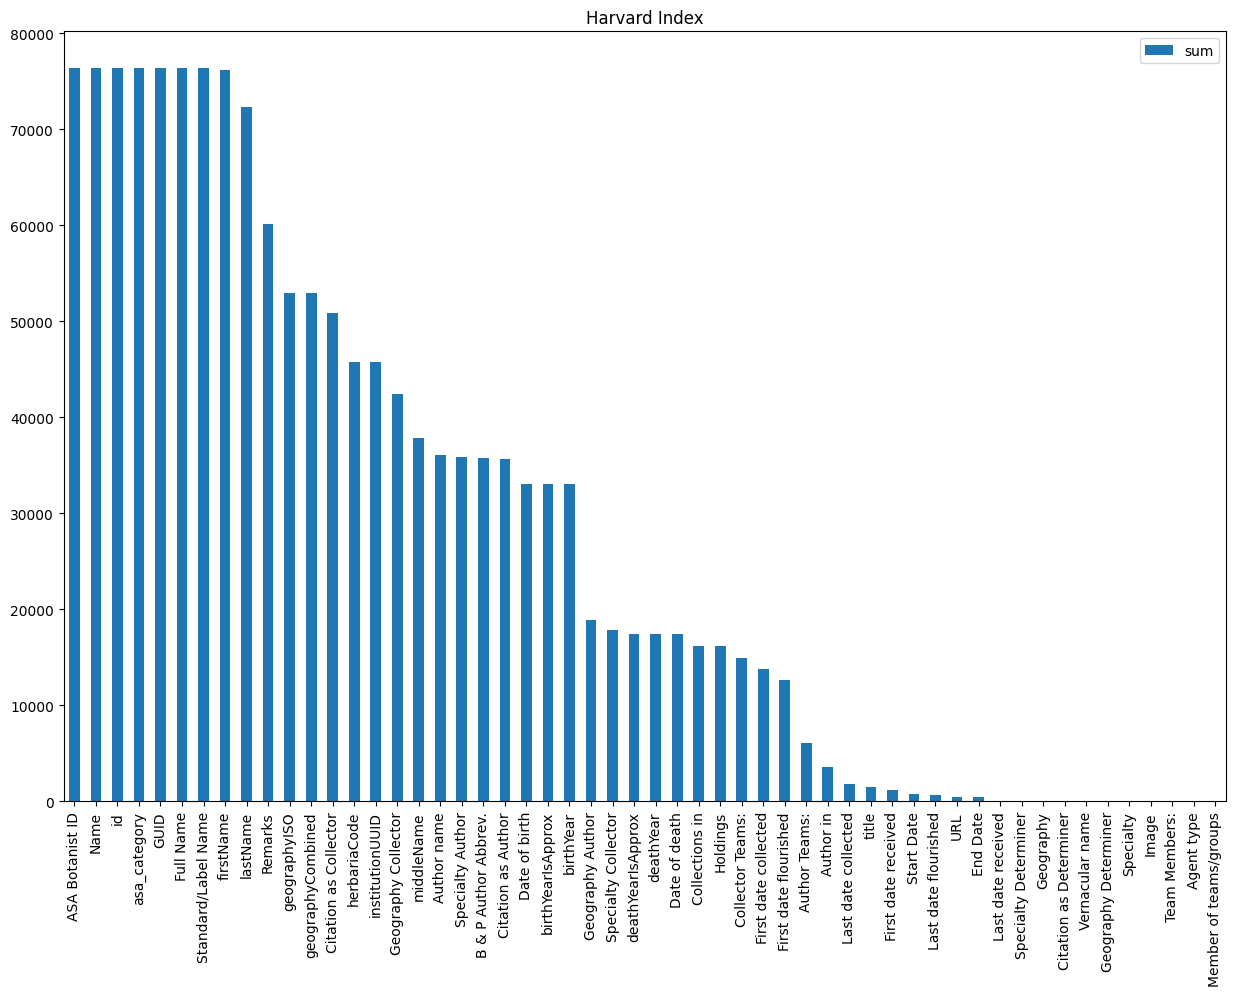

In [7]:
distribution = get_distribution(harvard_data, harvard_columns)
temp = distribution.T.sort_values(by=['sum'], ascending=False)
print(temp)
temp.plot.bar(figsize=(15,10), title = 'Harvard Index')

                  count
index             92480
other_names       92480
score             92480
has_occurrences   92480
is_public         92480
uri               92480
fullname          92480
fullname_reverse  92480
id                92480
description       92476
given             92469
family            92310
thumbnail         79904
label             56005
lifespan          50813
wikidata          50813
orcid             41666
orgs              15547
countries         15531


<Axes: title={'center': 'Bionomia'}>

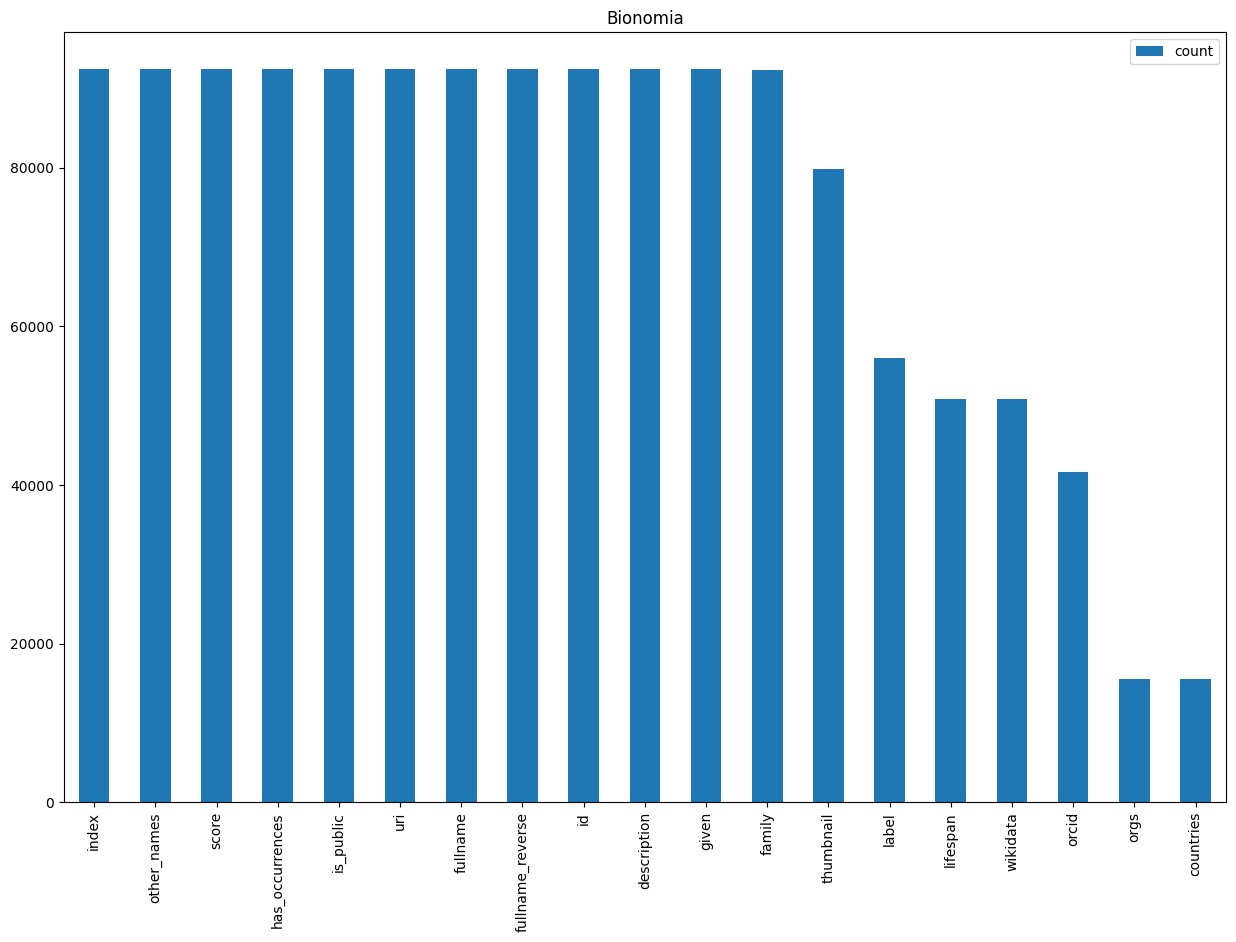

In [6]:
# Compute the sum of non-NaN or non-None counts for each column in the dataset.
# For Bionomia as this dataset has nontype value which is not suitable for value_counts
def get_non_nan_counts(data, columns):
    non_nan_counts = pd.DataFrame(columns=['count'], index=columns)
    for column in columns:
        try:
            non_nan_counts.at[column, 'count'] = data[column].notnull().sum()
        except Exception as e:
            print(f"Error processing column {column}: {e}")
            non_nan_counts.at[column, 'count'] = 0
    return non_nan_counts

# Example usage
non_nan_counts = get_non_nan_counts(bionomia_data, bionomia_columns)
non_nan_counts_sorted = non_nan_counts.sort_values(by=['count'], ascending=False)
print(non_nan_counts_sorted)

# Plot the results
non_nan_counts_sorted.plot.bar(figsize=(15, 10), title='Bionomia')

### Data Preprocessing

#### Helper functions

In [5]:
# For all
'''
# this function will remove all special charaters -- including spaces
# but too slow comparing to replace -- used process_time() for evaluation
def clean_text(text): # fa
    a = ""
    text = a.join(char for char in text if char.isalnum())
    return text
'''
# Remove square blankets auto generated during data alignment process
def clean_text(text): # fb
    text = text.replace('[', '').replace(']','').replace("'", '').replace("{", '').replace("}", '')
    return text

def remove_spec_in_col(df, col):
    newCol = []
    for index, rowValue in df[col].items():
        if pd.notnull(rowValue):
            newCol.append(clean_text(rowValue))
        else:
            newCol.append(np.nan)
    return newCol

def combine_name_list(df, colsList):
    nameList = []
    nameList = df[colsList].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    return nameList

# For Wikidata

def get_year(date_str):
    # Remove + sign
    if date_str[0] == '+':
        date_str = date_str[1:]
    return int(date_str[0:4])

def convert_date2year(df, col):
    newCol = []
    for index, rowValue in df[col].items():
        if pd.notnull(rowValue):
            newCol.append(get_year(rowValue))
        else:
            newCol.append(np.nan)
    return newCol

# For Bionomia

def get_lifespan_year(text):
    if pd.notnull(text):
        # Replace special characters and split by &ndash;
        text = text.replace('&#42;', '').replace('&ndash;', '|').replace("&dagger;", '')
        parts = text.split('|')  # Split by &ndash; (now '|')

        # Initialize birth year and death year
        birth_year = None
        death_year = None

        # Extract years from each part
        if len(parts) == 2:  # If there are two parts (birth and death)
            birth_year = re.search(r'\b\d{4}\b', parts[0])  # Look for 4-digit year in the first part
            death_year = re.search(r'\b\d{4}\b', parts[1])  # Look for 4-digit year in the second part

            # Extract the year or leave as None if no match
            birth_year = birth_year.group(0) if birth_year else None
            death_year = death_year.group(0) if death_year else None

        elif len(parts) == 1:  # If only one part exists (e.g., no &ndash;)
            single_year = re.search(r'\b\d{4}\b', parts[0])
            birth_year = single_year.group(0) if single_year else None

        # Return list of birth and death years
        return [birth_year, death_year]
    else:
        return [None, None]

def get_DoB_DoD(lifespan_list):
    if not lifespan_list or all(x is None or x is np.nan for x in lifespan_list):
        return [np.nan, np.nan]
    return lifespan_list

def get_lifespan_DoB_DoD(df, col):
    birth_years = []
    death_years = []
    for index, row_value in df[col].items():
        temp = get_DoB_DoD(get_lifespan_year(row_value))
        birth_years.append(temp[0])
        death_years.append(temp[1])
    return birth_years, death_years

def clean_accepted_names(accepted_names):
    # Step 1: Extract content inside square brackets
    inside_brackets = re.findall(r"\[.*?\]", accepted_names)
    if inside_brackets:
        # Clean and ensure proper separation within brackets
        inside_content = inside_brackets[0].strip('[]')  # Remove the outer brackets
        # Replace '\n' with a space and add commas between items separated only by spaces
        inside_cleaned = re.sub(r"\s{2,}", " ", inside_content.replace('\n', ' '))
        inside_cleaned = re.sub(r"'\s+'", "', '", inside_cleaned)  # Fix missing commas
        inside_cleaned = inside_cleaned.replace("'", '').strip()  # Remove single quotes
        # Replace the original bracketed content with cleaned content
        accepted_names = accepted_names.replace(inside_brackets[0], inside_cleaned)
    
    # Step 2: Remove remaining brackets, quotes, and extra spaces
    cleaned = accepted_names.replace('[', '').replace(']', '').replace("' '", ',').strip()
    cleaned = re.sub(r'\s+', ' ', cleaned)  # Replace multiple spaces with a single space
    
    # Step 3: Split by commas and clean individual parts
    parts = [part.strip() for part in cleaned.split(',')]
    cleaned = ', '.join(filter(bool, parts))  # Remove empty parts and join with commas
    
    return cleaned.replace("' '",", ").replace("'","")

In [6]:
# For Harvard Index
# Functions to extract the herbarium institution codes from Remarks in Harvard Index
def get_herbarium_codes(string):
    herbarium_codes = []
    for s in string.split(","):
        if s.isupper():
            herbarium_codes.append(re.sub('[^A-Z]', ',', s).replace(",",""))
    return herbarium_codes
            
def get_author_notes(string):
    authorNotes = []
    for s in string:
        # s = clean_text(s)
        # authorNotes.append(s.partition("author note: ")[2].partition(" ")[0].replace(";", ''))
        authorNotes.append(s.partition("author note: ")[2].partition("]")[0].replace(";", ',').replace(":", ',').replace("(",",").replace(")",",").replace("at",","))
    authorNotes = list(filter(None, authorNotes))
    return authorNotes

def get_collector_notes(string):
    collectorNotes = []
    for s in string:
        # s = clean_text(s)
        # collectorNotes.append(s.partition("collector note: ")[2].partition(" ")[0].replace(";", ''))
        collectorNotes.append(s.partition("collector note: ")[2].partition("]")[0].replace(";", ',').replace(":", ',').replace("(",",").replace(")",",").replace("at",","))
    collectorNotes = list(filter(None, collectorNotes))
    return collectorNotes

def get_author_collector_notes(df, col):
    authorNoteCol = []
    collectorNoteCol = []
    for index, rowValue in df[col].items():
        if pd.notnull(rowValue):
            string = rowValue.split("[")
            authorNoteCol.append(get_author_notes(string))
            collectorNoteCol.append(get_collector_notes(string))
        else:
            authorNoteCol.append([]) # use empty to reduce runtime exception while condition checking
            collectorNoteCol.append([])
    return authorNoteCol, collectorNoteCol

def extract_herbariums(df, col):
    newCol = []
    for index, rowValue in df[col].items():
        if rowValue:
            temp = []
            # for i in rowValue: temp = get_herbarium_codes(i)
            for i in rowValue: 
                temp += get_herbarium_codes(i)
            newCol.append(temp)
        else:
            newCol.append([])
    return newCol

# Replace empty list as np.nan
def remove_empty(df, col):
    newCol = []
    for index, rowValue in df[col].items():
        if not rowValue:
            newCol.append(np.nan)
        else:
            newCol.append(rowValue)
    return newCol

In [7]:
def merge_wiki_geo(df):
    def clean_entry(entry):
        # Handle sets: convert to strings and clean 'None'
        if isinstance(entry, set):
            # Remove 'None' from sets and join remaining elements
            cleaned_set = {x for x in entry if x != 'None'}
            return ', '.join(cleaned_set) if cleaned_set else np.nan
    
        # Handle strings: clean multiple occurrences of 'None'
        elif isinstance(entry, str):
            # Split the string into parts, remove 'None', and rejoin
            cleaned = ', '.join(part.strip() for part in entry.split(',') if part.strip() != 'None')
            return cleaned if cleaned else np.nan  # Replace empty results with NaN
    
        # Return NaN for other invalid types (e.g., float NaN)
        else:
            return entry

    # Clean both columns
    df['countriesOfCitizenship'] = df['countriesOfCitizenship'].apply(clean_entry)
    df['employerCountries'] = df['employerCountries'].apply(clean_entry)

    # Merge columns, prioritizing countriesOfCitizenship and filling with employerCountries
    return df['countriesOfCitizenship'].combine_first(df['employerCountries'])

#### Data cleaning and preprocessing

In [32]:
a = wiki_data[['qid','name','dateOfBirth','dateOfDeath','countriesOfCitizenship',
              'harvardIndex','bionomia','authorAbbrv','aliases','employers','employerCountries']].copy()
a['firstName'] = a['name'].str.split('\s+').str[0]
a['lastName'] = a['name'].str.split('\s+').str[-1]
a['dateOfBirth'] = convert_date2year(a,'dateOfBirth')
a['dateOfDeath'] = convert_date2year(a,'dateOfDeath')
a['employers'] = remove_spec_in_col(a,'employers')
a['aliases'] = remove_spec_in_col(a,'aliases')
a['countriesOfCitizenship'] = remove_spec_in_col(a,'countriesOfCitizenship')
a['employerCountries'] = remove_spec_in_col(a,'employerCountries')
a['harvardIndex'] = pd.to_numeric(a['harvardIndex'],errors='coerce')
a['countries'] = merge_wiki_geo(a)
cols_to_drop = ['countriesOfCitizenship', 'employerCountries', 'employers']
a.drop(cols_to_drop, axis=1, inplace=True)
a.head()

,qid,name,dateOfBirth,dateOfDeath,harvardIndex,bionomia,authorAbbrv,aliases,firstName,lastName,countries
0,Q100142069,Frida Eggens,NaN,NaN,NaN,NaN,Eggens,Eggens,Frida,Eggens,SE
1,Q100146795,Elizabeth Harrison,1792.0,1834.0,NaN,Q100146795,NaN,"Mrs Arnold Harrison, Mrs A. H.",Elizabeth,Harrison,NaN
2,Q100149196,Russell Cox,NaN,NaN,NaN,0000-0001-5149-1709,NaN,,Russell,Cox,AU
3,Q100152296,Alda Pereira da Fonseca,1882.0,NaN,NaN,NaN,NaN,,Alda,Fonseca,NaN
4,Q100156193,Laurence Henry Millener,1914.0,2000.0,NaN,Q100156193,NaN,"L. H. Millener, Laurie Henry Millener, Laurie ...",Laurence,Millener,NZ


In [33]:
b = harvard_data[['id','Standard/Label Name','birthYear','deathYear','birthYearIsApprox','geographyISO','herbariaCode',
                 'firstName','middleName','lastName','B & P Author Abbrev.','Name','Remarks']].copy()
b.rename(columns={"birthYear": "dateOfBirth", "deathYear": "dateOfDeath", "Standard/Label Name":"label", 
                  "B & P Author Abbrev.":"authorAbbrv"}, inplace=True)
b['Name'] = remove_spec_in_col(b,'Name')
b['geographyISO'] = remove_spec_in_col(b,'geographyISO')
b['herbariaCode'] = remove_spec_in_col(b,'herbariaCode')
temp0, temp1 = get_author_collector_notes(b, 'Remarks')
b['author note'] = temp0
b['collector note'] = temp1
b['author note'] = extract_herbariums(b,'author note')
cols_to_drop = ['Remarks','collector note']
b.drop(cols_to_drop, axis=1, inplace=True)
b.head()

,id,label,dateOfBirth,dateOfDeath,birthYearIsApprox,geographyISO,herbariaCode,firstName,middleName,lastName,authorAbbrv,Name,author note
0,5,A. R. Brach,NaN,NaN,NaN,US,SYRF,Anthony,Robert,Brach,Brach,"Brach, Anthony Robert, Anthony Robert Brach",[SYRF]
1,6,B. C. Tan,1947.0,2016.0,False,"PH, SG, CN, MY, US, ID","UBC, H, SINU, B, FH",Benito,Ching,Tan,B.C.Tan,"Tan, Benito Ching, Ben Ching Tan",[]
2,7,E. W. Wood,NaN,NaN,NaN,"US, JP","TI, NCU, KYO, PE, CM, MO, A, CAS, GH",Emily,Walker,Wood,E.W.Wood,"Wood, Emily Walker, Emily Walker Wood",[]
3,8,W. T. Kittredge,1953.0,NaN,False,US,"NEBC, GH, AMES",Walter,Tobey,Kittredge,W. Kittr.,"Kittredge, Walter Tobey, Kittredge, W. T.",[AMES]
4,9,G. J. Cacavio,1948.0,NaN,False,US,GH,Gennaro,J.,Cacavio,NaN,"Cacavio, Gennaro J.",[]


In [34]:
c = bionomia_data[['id','orcid','wikidata','fullname','fullname_reverse','label','given','family',
                   'orgs','countries','other_names','lifespan']].copy()
dob, dod = get_lifespan_DoB_DoD(c, 'lifespan')
c['dateOfBirth'] = dob
c['dateOfDeath'] = dod
c.rename(columns={"given":"firstName", "family":"lastName"}, inplace=True)
# c['acceptedNames'] = c['other_names'].apply(lambda x: '' if isinstance(x, list) and not x else str(x)) \
#                       + ', ' + c['fullname_reverse'].fillna('').astype(str).str.replace(',', '')
c['acceptedNames'] = c['other_names'].apply(lambda x: '' if isinstance(x, list) and not x else str(x))
c['acceptedNames'] = c['acceptedNames'].apply(clean_accepted_names)
cols_to_drop = ['lifespan', 'fullname_reverse','other_names']
c.drop(cols_to_drop, axis=1, inplace=True)
c.head()

,id,orcid,wikidata,fullname,label,firstName,lastName,orgs,countries,dateOfBirth,dateOfDeath,acceptedNames
0,88053,None,Q108887181,A. R. Christiaensen,A. R. Christiaensen,A. R.,Christiaensen,None,None,None,1966,A. Christiaensen
1,2778,0000-0001-7348-143X,None,Fabian A. Michelangeli,None,Fabian A.,Michelangeli,Q636275,US,NaN,NaN,"F. A. Michelangeli, Fabian A. Michelangeli, F...."
2,122362,None,Q113612396,J. G. A. Salmin,J. G. A. Salmin,J. G. A.,Salmin,None,None,NaN,NaN,"J.G.A. Salmin, Salmin"
3,68322,0000-0001-5980-1417,None,Jairo A. Moreno-González,None,Jairo A.,Moreno-González,None,None,NaN,NaN,
4,124267,None,Q130018104,A.C. Persaud,A.C. Persaud,A.C.,Persaud,None,None,None,1925,


#### Training data's Ground Truth

In [26]:
def define_true_pairs(indexList1, indexList2, indexName1, indexName2):
    arrays = [indexList1, indexList2]
    tuples = list(zip(*arrays))
    index = pd.MultiIndex.from_tuples(tuples, names=[indexName1, indexName2])
    return index

In [27]:
a['wikiID'] = a['qid']
a = a.set_index('qid')
b['harvardIndex'] = b['id']
b = b.set_index('id')

# Find out the True Matches of dataframe A and dataframe B
temp = pd.merge(a, b, how='inner', on=None, left_on='harvardIndex', right_on='harvardIndex',
                  left_index=False, right_index=False, sort=False,
                  suffixes=('_wiki', '_harvard'), copy=False, indicator=False)

true_matches = define_true_pairs(temp['wikiID'],temp['harvardIndex'].astype(int),'wikiID','harvardIndex')
print('There is '+ str(len(true_matches)) +' HarvardIndex records in Wikidata that can find a match, which is ' + str(len(true_matches)/len(a)*100) +'%')
print('There is '+ str(len(true_matches)) +' HarvardIndex records can be found in Wikidata, which is ' + str(len(true_matches)/len(b)*100) +'%')

There is 35525 HarvardIndex records in Wikidata that can find a match, which is 46.18014481261456%
There is 35525 HarvardIndex records can be found in Wikidata, which is 46.50416933932008%


In [28]:
# Find non-matched pairs in dataframe a
non_matched_a = a[~a['harvardIndex'].isin(temp['harvardIndex']) & a['harvardIndex'].notna()]
# Find non-matched pairs in dataframe b
non_matched_b = b[~b['harvardIndex'].isin(temp['harvardIndex']) & b['harvardIndex'].notnull()]
print('Non-matched data where HarvardIndex is not null or NaN:')
print('There is '+ str(len(non_matched_a)) +' HarvardIndex records in Wikidata which cannot be found in HarvardIndex, which is ' + str(len(non_matched_a)/len(a)*100) +'%')
print('There is '+ str(len(non_matched_b)) +' HarvardIndex records cannot find a match, which is ' + str(len(non_matched_b)/len(b)*100) +'%')

Non-matched data where HarvardIndex is not null or NaN:
There is 3193 HarvardIndex records in Wikidata which cannot be found in HarvardIndex, which is 4.15068831489594%
There is 40908 HarvardIndex records cannot find a match, which is 53.55081095940621%


### Methodology: Record Linkage

#### Self-defined comparison function for feature checking

In [29]:
# Custom comparison class for checking if a label exists in aliases.
class CompareAliases(recordlinkage.base.BaseCompareFeature):
    def __init__(self, labels_left, labels_right, label="custom_alias_feature"):
        """
        Initialize the custom feature.

        Parameters:
            labels_left (str): Column name in the left DataFrame (aliases).
            labels_right (str): Column name in the right DataFrame (label).
            label (str): Feature label.
        """
        super().__init__(labels_left=labels_left, labels_right=labels_right, label=label)

    def _compute_vectorized(self, left_column, right_column):
        """
        Compute the custom feature for label-in-aliases matching.

        Parameters:
            left_column (pd.Series): The aliases column from the left DataFrame.
            right_column (pd.Series): The label column from the right DataFrame.

        Returns:
            pd.Series: A Series where each element is 1 if a match is found, else 0.
        """
        # Ensure input columns are strings
        left_column = left_column.fillna("").str.lower()
        right_column = right_column.fillna("").str.lower()

        # Initialize result series with zeros
        result = pd.Series(0, index=left_column.index)

        # Compare each pair
        for idx, (aliases, label) in enumerate(zip(left_column, right_column)):
            aliases_set = set(alias.strip() for alias in aliases.split(','))
            if label in aliases_set:
                result.iloc[idx] = 1  # Match found

        return result

### Experiment and Evaluation

#### Group One: Wikidata with the Harvard Index
##### Experiment One: lastName + firstName + dateOfBirth

In [20]:
dfa = a.copy()
dfb = b.copy()
indexer = recordlinkage.Index()
indexer.sortedneighbourhood('lastName')# indexer.sortedneighbourhood indexer.full() indexer.block
candidate_links = indexer.index(dfa, dfb)

In [39]:
compare_cl = recordlinkage.Compare()
# method options: ‘jaro’, ’jarowinkler’, ‘levenshtein’, ‘damerau_levenshtein’, ‘qgram’ or ‘cosine’.
compare_cl.string('firstName', 'firstName', method='damerau_levenshtein', threshold=0.85, label='firstName')
compare_cl.exact('dateOfBirth', 'dateOfBirth', label='dateOfBirth')

features = compare_cl.compute(candidate_links, dfa, dfb)
features.sum(axis=1).value_counts().sort_index(ascending=False)

# Create a training and test set
train, test = train_test_split(features, test_size=0.25, random_state=42) # random_state=42

# Get the true pairs for the test set (Used for Evaluation)
test_matches_index = test.index.intersection(true_matches)

# Threshold-based methods

print("Training with threshold-based methods")
# Make Predictions based on threshold > 50%
predictions = features[features.sum(axis=1) >= 1]
print("Threshold-Based: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(true_matches, predictions, len(features))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))

# Return all the true matched feature as test set
# test_matches_index = features.index.intersection(true_matches)
# print(test_matches_index)


# Expectation/Conditional Maxisation Classifier

print("\nTraining with Expectation/Conditional Maxisation Classifier")
# Initialize the classifier
ecm = recordlinkage.ECMClassifier()
# Train the Model
train_ecm = ecm.fit_predict(train)
# Make Predictions on a test set
predictions = ecm.predict(test)
print("Expectation/Conditional Maxisation: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))


# K-means Classifier
# Initialize the classifier
print("\nTraining with K-means Classifier")
kmeans = recordlinkage.KMeansClassifier()

# Train the Model
train_kmeans = kmeans.fit_predict(train)
# Make Predictions on a test set
predictions = kmeans.predict(test)
print("K-means: {} matches".format(len(predictions)))
# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))


# Create a training and test set
train, test = train_test_split(features, test_size=0.25, random_state=42)
# Get the true pairs for each set
train_matches_index = train.index.intersection(true_matches)
test_matches_index = test.index.intersection(true_matches)

# Logistic Regression
# Initialize the classifier
print("\nTraining with Logistic Regression")
logisticRegression = recordlinkage.LogisticRegressionClassifier()

# Train the classifier
logisticRegression.fit_predict(train, train_matches_index)

# Make Predictions on a test set
predictions = logisticRegression.predict(test)
print("Logistic Regression: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))


# Support Vector Machine Classifier
# Initialize the classifier
print("\nTraining with Support Vector Machine")
svm = recordlinkage.SVMClassifier()

# Train the classifier
svm.fit_predict(train, train_matches_index)

# Make Predictions on a test set
predictions = svm.predict(test)
print("Support Vector Machine: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))


# Naive Bayes Classifier
# Initialize the classifier
print("\nTraining with Naive Bayes Classifier")
naiveBayes = recordlinkage.NaiveBayesClassifier()

# Train the classifier
naiveBayes.fit_predict(train, train_matches_index)

# Make Predictions on a test set
predictions = naiveBayes.predict(test)
print("Naive Bayes: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))

Training with threshold-based methods
Threshold-Based: 41027 matches
Confusion Matrix:
 [[  27643    7882]
 [  13384 1005623]]
Precision: 0.6737758061764204
Recall: 0.7781280788177339
Accuracy: 0.9798337082231738
F-Measure: 0.722201901975128

Training with Expectation/Conditional Maxisation Classifier
Expectation/Conditional Maxisation: 4624 matches
Confusion Matrix:
 [[  4023   3988]
 [   601 255021]]
Precision: 0.8700259515570934
Recall: 0.5021844963175633
Accuracy: 0.9825932261894376
F-Measure: 0.6368025326474079

Training with K-means Classifier
K-means: 10301 matches
Confusion Matrix:
 [[  6950   1061]
 [  3351 252271]]
Precision: 0.6746917774973303
Recall: 0.8675571089751591
Accuracy: 0.9832646140657657
F-Measure: 0.7590650939274793

Training with Logistic Regression
Logistic Regression: 4624 matches
Confusion Matrix:
 [[  4023   3988]
 [   601 255021]]
Precision: 0.8700259515570934
Recall: 0.5021844963175633
Accuracy: 0.9825932261894376
F-Measure: 0.6368025326474079

Training wi

##### Experiment Two: lastName + firstName + dateOfBirth + Namelist

In [33]:
compare_cl = recordlinkage.Compare()
# method options: ‘jaro’, ’jarowinkler’, ‘levenshtein’, ‘damerau_levenshtein’, ‘qgram’ or ‘cosine’.
compare_cl.string('firstName', 'firstName', method='damerau_levenshtein', threshold=0.85, label='firstName')
compare_cl.exact('dateOfBirth', 'dateOfBirth', label='dateOfBirth')
compare_cl.add(CompareAliases('aliases', 'label', label='custom_alias_feature'))

features = compare_cl.compute(candidate_links, dfa, dfb)
features.sum(axis=1).value_counts().sort_index(ascending=False)

# Create a training and test set
train, test = train_test_split(features, test_size=0.25, random_state=42) # random_state=42

# Get the true pairs for the test set (Used for Evaluation)
test_matches_index = test.index.intersection(true_matches)

# Threshold-based methods

print("Training with threshold-based methods")
# Make Predictions based on threshold > 50%
predictions = features[features.sum(axis=1) > 1.5]
print("Threshold-Based: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(true_matches, predictions, len(features))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))

# Return all the true matched feature as test set
# test_matches_index = features.index.intersection(true_matches)
# print(test_matches_index)


# Expectation/Conditional Maxisation Classifier

print("\nTraining with Expectation/Conditional Maxisation Classifier")
# Initialize the classifier
ecm = recordlinkage.ECMClassifier()
# Train the Model
train_ecm = ecm.fit_predict(train)
# Make Predictions on a test set
predictions = ecm.predict(test)
print("Expectation/Conditional Maxisation: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))


# K-means Classifier
# Initialize the classifier
print("\nTraining with K-means Classifier")
kmeans = recordlinkage.KMeansClassifier()

# Train the Model
train_kmeans = kmeans.fit_predict(train)
# Make Predictions on a test set
predictions = kmeans.predict(test)
print("K-means: {} matches".format(len(predictions)))
# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))


# Create a training and test set
train, test = train_test_split(features, test_size=0.25, random_state=42)
# Get the true pairs for each set
train_matches_index = train.index.intersection(true_matches)
test_matches_index = test.index.intersection(true_matches)

# Logistic Regression
# Initialize the classifier
print("\nTraining with Logistic Regression")
logisticRegression = recordlinkage.LogisticRegressionClassifier()

# Train the classifier
logisticRegression.fit_predict(train, train_matches_index)

# Make Predictions on a test set
predictions = logisticRegression.predict(test)
print("Logistic Regression: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))


# Support Vector Machine Classifier
# Initialize the classifier
print("\nTraining with Support Vector Machine")
svm = recordlinkage.SVMClassifier()

# Train the classifier
svm.fit_predict(train, train_matches_index)

# Make Predictions on a test set
predictions = svm.predict(test)
print("Support Vector Machine: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))


# Naive Bayes Classifier
# Initialize the classifier
print("\nTraining with Naive Bayes Classifier")
naiveBayes = recordlinkage.NaiveBayesClassifier()

# Train the classifier
naiveBayes.fit_predict(train, train_matches_index)

# Make Predictions on a test set
predictions = naiveBayes.predict(test)
print("Naive Bayes: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))

Training with threshold-based methods
Threshold-Based: 23783 matches
Confusion Matrix:
 [[  20841   14684]
 [   2942 1016065]]
Precision: 0.8762981961905563
Recall: 0.5866572836030964
Accuracy: 0.9832854764009058
F-Measure: 0.7028056923180683

Training with Expectation/Conditional Maxisation Classifier
Expectation/Conditional Maxisation: 9232 matches
Confusion Matrix:
 [[  6551   1460]
 [  2681 252941]]
Precision: 0.7095970537261699
Recall: 0.8177505929347147
Accuracy: 0.984292558215398
F-Measure: 0.7598445746099868

Training with K-means Classifier
K-means: 9232 matches
Confusion Matrix:
 [[  6551   1460]
 [  2681 252941]]
Precision: 0.7095970537261699
Recall: 0.8177505929347147
Accuracy: 0.984292558215398
F-Measure: 0.7598445746099868

Training with Logistic Regression
Logistic Regression: 5997 matches
Confusion Matrix:
 [[  5286   2725]
 [   711 254911]]
Precision: 0.8814407203601801
Recall: 0.6598427162651355
Accuracy: 0.9869667302651792
F-Measure: 0.7547115933752143

Training with

##### Experiment Three: lastName + firstName + dateOfBirth + dateOfDeath + Namelist

In [34]:
compare_cl = recordlinkage.Compare()
# method options: ‘jaro’, ’jarowinkler’, ‘levenshtein’, ‘damerau_levenshtein’, ‘qgram’ or ‘cosine’.
compare_cl.string('firstName', 'firstName', method='damerau_levenshtein', threshold=0.85, label='firstName')
compare_cl.exact('dateOfBirth', 'dateOfBirth', label='dateOfBirth')
compare_cl.exact('dateOfDeath', 'dateOfDeath', label='dateOfDeath')
compare_cl.add(CompareAliases('aliases', 'label', label='custom_alias_feature'))

features = compare_cl.compute(candidate_links, dfa, dfb)
features.sum(axis=1).value_counts().sort_index(ascending=False)

# Create a training and test set
train, test = train_test_split(features, test_size=0.25, random_state=42) # random_state=42

# Get the true pairs for the test set (Used for Evaluation)
test_matches_index = test.index.intersection(true_matches)

# Threshold-based methods

print("Training with threshold-based methods")
# Make Predictions based on threshold > 50%
predictions = features[features.sum(axis=1) > 1.5]
print("Threshold-Based: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(true_matches, predictions, len(features))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))

# Return all the true matched feature as test set
# test_matches_index = features.index.intersection(true_matches)
# print(test_matches_index)


# Expectation/Conditional Maxisation Classifier

print("\nTraining with Expectation/Conditional Maxisation Classifier")
# Initialize the classifier
ecm = recordlinkage.ECMClassifier()
# Train the Model
train_ecm = ecm.fit_predict(train)
# Make Predictions on a test set
predictions = ecm.predict(test)
print("Expectation/Conditional Maxisation: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))


# K-means Classifier
# Initialize the classifier
print("\nTraining with K-means Classifier")
kmeans = recordlinkage.KMeansClassifier()

# Train the Model
train_kmeans = kmeans.fit_predict(train)
# Make Predictions on a test set
predictions = kmeans.predict(test)
print("K-means: {} matches".format(len(predictions)))
# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))


# Create a training and test set
train, test = train_test_split(features, test_size=0.25, random_state=42)
# Get the true pairs for each set
train_matches_index = train.index.intersection(true_matches)
test_matches_index = test.index.intersection(true_matches)

# Logistic Regression
# Initialize the classifier
print("\nTraining with Logistic Regression")
logisticRegression = recordlinkage.LogisticRegressionClassifier()

# Train the classifier
logisticRegression.fit_predict(train, train_matches_index)

# Make Predictions on a test set
predictions = logisticRegression.predict(test)
print("Logistic Regression: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))


# Support Vector Machine Classifier
# Initialize the classifier
print("\nTraining with Support Vector Machine")
svm = recordlinkage.SVMClassifier()

# Train the classifier
svm.fit_predict(train, train_matches_index)

# Make Predictions on a test set
predictions = svm.predict(test)
print("Support Vector Machine: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))


# Naive Bayes Classifier
# Initialize the classifier
print("\nTraining with Naive Bayes Classifier")
naiveBayes = recordlinkage.NaiveBayesClassifier()

# Train the classifier
naiveBayes.fit_predict(train, train_matches_index)

# Make Predictions on a test set
predictions = naiveBayes.predict(test)
print("Naive Bayes: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))

Training with threshold-based methods
Threshold-Based: 25661 matches
Confusion Matrix:
 [[  22230   13295]
 [   3431 1015576]]
Precision: 0.8662951560734188
Recall: 0.6257565095003519
Accuracy: 0.9841389355657296
F-Measure: 0.7266368123426927

Training with Expectation/Conditional Maxisation Classifier
Expectation/Conditional Maxisation: 6577 matches
Confusion Matrix:
 [[  5638   2373]
 [   939 254683]]
Precision: 0.8572297400030409
Recall: 0.7037822993384096
Accuracy: 0.9874370810937932
F-Measure: 0.7729640800658075

Training with K-means Classifier
K-means: 6426 matches
Confusion Matrix:
 [[  5610   2401]
 [   816 254806]]
Precision: 0.873015873015873
Recall: 0.7002871052303083
Accuracy: 0.9877974305189411
F-Measure: 0.7771697721133201

Training with Logistic Regression
Logistic Regression: 6137 matches
Confusion Matrix:
 [[  5392   2619]
 [   745 254877]]
Precision: 0.8786051816848623
Recall: 0.6730745225315191
Accuracy: 0.9872398371979229
F-Measure: 0.7622278767316936

Training wit

#### Group Two: Wikidata with the Bionomia
##### Experiment One: lastName + firstName + dateOfBirth

In [40]:
c['bioID'] = c['id']
c = c.set_index('id')

# Find out the ground truth matches of wikidata and bionomia using id in the records
temp = pd.merge(a, c, how='inner', on=None, left_on='wikiID', right_on='wikidata',
                  left_index=False, right_index=False, sort=False,
                  suffixes=('_wiki', '_bionomia'), copy=False, indicator=False)

true_matches = define_true_pairs(temp['wikiID'],temp['bioID'].astype(int),'wikiID','bioID')
# print("\nWikiID and bionomia pairs as true matches:")
# print(true_matches)

# Print out the precentage
print('There are '+ str(len(true_matches)) +' Bionomia records in Wikidata, which is ' + str(len(true_matches)/len(a)*100) +'%')
print('There are '+ str(len(true_matches)) +' Wikidata records in Bionomia, which is ' + str(len(true_matches)/len(c)*100) +'%')


There are 26806 Bionomia records in Wikidata, which is 34.84602285283451%
There are 26806 Wikidata records in Bionomia, which is 28.985726643598614%


In [41]:
dfa = a.copy()
dfc = c.copy()

dfc['dateOfBirth'] = pd.to_numeric(dfc['dateOfBirth'], errors='coerce')
dfc['dateOfDeath'] = pd.to_numeric(dfc['dateOfDeath'], errors='coerce')

indexer = recordlinkage.Index()
indexer.sortedneighbourhood('lastName')# indexer.sortedneighbourhood indexer.full() indexer.block
candidate_links = indexer.index(dfa, dfc)

In [45]:
compare_cl = recordlinkage.Compare()
# method options: ‘jaro’, ’jarowinkler’, ‘levenshtein’, ‘damerau_levenshtein’, ‘qgram’ or ‘cosine’.
compare_cl.string('firstName', 'firstName', method='damerau_levenshtein', threshold=0.85, label='firstName')
compare_cl.exact('dateOfBirth', 'dateOfBirth', label='dateOfBirth')

features = compare_cl.compute(candidate_links, dfa, dfc)
features.sum(axis=1).value_counts().sort_index(ascending=False)

# Create a training and test set
train, test = train_test_split(features, test_size=0.25, random_state=42) # random_state=42

# Get the true pairs for the test set (Used for Evaluation)
test_matches_index = test.index.intersection(true_matches)

# Threshold-based methods

print("Training with threshold-based methods")
# Make Predictions based on threshold > 50%
predictions = features[features.sum(axis=1) >= 1]
print("Threshold-Based: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(true_matches, predictions, len(features))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))

# Return all the true matched feature as test set
# test_matches_index = features.index.intersection(true_matches)
# print(test_matches_index)


# Expectation/Conditional Maxisation Classifier

print("\nTraining with Expectation/Conditional Maxisation Classifier")
# Initialize the classifier
ecm = recordlinkage.ECMClassifier()
# Train the Model
train_ecm = ecm.fit_predict(train)
# Make Predictions on a test set
predictions = ecm.predict(test)
print("Expectation/Conditional Maxisation: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))


# K-means Classifier
# Initialize the classifier
print("\nTraining with K-means Classifier")
kmeans = recordlinkage.KMeansClassifier()

# Train the Model
train_kmeans = kmeans.fit_predict(train)
# Make Predictions on a test set
predictions = kmeans.predict(test)
print("K-means: {} matches".format(len(predictions)))
# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))


# Create a training and test set
train, test = train_test_split(features, test_size=0.25, random_state=42)
# Get the true pairs for each set
train_matches_index = train.index.intersection(true_matches)
test_matches_index = test.index.intersection(true_matches)

# Logistic Regression
# Initialize the classifier
print("\nTraining with Logistic Regression")
logisticRegression = recordlinkage.LogisticRegressionClassifier()

# Train the classifier
logisticRegression.fit_predict(train, train_matches_index)

# Make Predictions on a test set
predictions = logisticRegression.predict(test)
print("Logistic Regression: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))


# Support Vector Machine Classifier
# Initialize the classifier
print("\nTraining with Support Vector Machine")
svm = recordlinkage.SVMClassifier()

# Train the classifier
svm.fit_predict(train, train_matches_index)

# Make Predictions on a test set
predictions = svm.predict(test)
print("Support Vector Machine: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))


# Naive Bayes Classifier
# Initialize the classifier
print("\nTraining with Naive Bayes Classifier")
naiveBayes = recordlinkage.NaiveBayesClassifier()

# Train the classifier
naiveBayes.fit_predict(train, train_matches_index)

# Make Predictions on a test set
predictions = naiveBayes.predict(test)
print("Naive Bayes: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))

Training with threshold-based methods
Threshold-Based: 35194 matches
Confusion Matrix:
 [[ 24560   2246]
 [ 10634 972030]]
Precision: 0.6978462237881458
Recall: 0.9162127881817503
Accuracy: 0.9872408293460925
F-Measure: 0.7922580645161291

Training with Expectation/Conditional Maxisation Classifier
Expectation/Conditional Maxisation: 4242 matches
Confusion Matrix:
 [[  4189   2008]
 [    53 246118]]
Precision: 0.9875058934464875
Recall: 0.6759722446345006
Accuracy: 0.9918333544664933
F-Measure: 0.8025672957179807

Training with K-means Classifier
K-means: 8766 matches
Confusion Matrix:
 [[  6138     59]
 [  2628 243543]]
Precision: 0.7002053388090349
Recall: 0.9904792641600775
Accuracy: 0.9893528498066316
F-Measure: 0.8204237118224954

Training with Logistic Regression
Logistic Regression: 6468 matches
Confusion Matrix:
 [[  5980    217]
 [   488 245683]]
Precision: 0.9245516388373531
Recall: 0.964983056317573
Accuracy: 0.9972064604070247
F-Measure: 0.9443347808922227

Training with Su

##### Experiment Two: lastName + firstName + dateOfBirth + Namelist

In [46]:
compare_cl = recordlinkage.Compare()
# method options: ‘jaro’, ’jarowinkler’, ‘levenshtein’, ‘damerau_levenshtein’, ‘qgram’ or ‘cosine’.
compare_cl.string('firstName', 'firstName', method='damerau_levenshtein', threshold=0.85, label='firstName')
compare_cl.exact('dateOfBirth', 'dateOfBirth', label='dateOfBirth')
compare_cl.add(CompareAliases('aliases', 'label', label='custom_alias_feature'))

features = compare_cl.compute(candidate_links, dfa, dfc)
features.sum(axis=1).value_counts().sort_index(ascending=False)

# Create a training and test set
train, test = train_test_split(features, test_size=0.25, random_state=42) # random_state=42

# Get the true pairs for the test set (Used for Evaluation)
test_matches_index = test.index.intersection(true_matches)

# Threshold-based methods

print("Training with threshold-based methods")
# Make Predictions based on threshold > 50%
predictions = features[features.sum(axis=1) > 1.5]
print("Threshold-Based: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(true_matches, predictions, len(features))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))

# Return all the true matched feature as test set
# test_matches_index = features.index.intersection(true_matches)
# print(test_matches_index)


# Expectation/Conditional Maxisation Classifier

print("\nTraining with Expectation/Conditional Maxisation Classifier")
# Initialize the classifier
ecm = recordlinkage.ECMClassifier()
# Train the Model
train_ecm = ecm.fit_predict(train)
# Make Predictions on a test set
predictions = ecm.predict(test)
print("Expectation/Conditional Maxisation: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))


# K-means Classifier
# Initialize the classifier
print("\nTraining with K-means Classifier")
kmeans = recordlinkage.KMeansClassifier()

# Train the Model
train_kmeans = kmeans.fit_predict(train)
# Make Predictions on a test set
predictions = kmeans.predict(test)
print("K-means: {} matches".format(len(predictions)))
# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))


# Create a training and test set
train, test = train_test_split(features, test_size=0.25, random_state=42)
# Get the true pairs for each set
train_matches_index = train.index.intersection(true_matches)
test_matches_index = test.index.intersection(true_matches)

# Logistic Regression
# Initialize the classifier
print("\nTraining with Logistic Regression")
logisticRegression = recordlinkage.LogisticRegressionClassifier()

# Train the classifier
logisticRegression.fit_predict(train, train_matches_index)

# Make Predictions on a test set
predictions = logisticRegression.predict(test)
print("Logistic Regression: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))


# Support Vector Machine Classifier
# Initialize the classifier
print("\nTraining with Support Vector Machine")
svm = recordlinkage.SVMClassifier()

# Train the classifier
svm.fit_predict(train, train_matches_index)

# Make Predictions on a test set
predictions = svm.predict(test)
print("Support Vector Machine: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))


# Naive Bayes Classifier
# Initialize the classifier
print("\nTraining with Naive Bayes Classifier")
naiveBayes = recordlinkage.NaiveBayesClassifier()

# Train the classifier
naiveBayes.fit_predict(train, train_matches_index)

# Make Predictions on a test set
predictions = naiveBayes.predict(test)
print("Naive Bayes: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))

Training with threshold-based methods
Threshold-Based: 18068 matches
Confusion Matrix:
 [[ 17035   9771]
 [  1033 981631]]
Precision: 0.9428270976311711
Recall: 0.6354920540177572
Accuracy: 0.9892973540570794
F-Measure: 0.7592369746401034

Training with Expectation/Conditional Maxisation Classifier
Expectation/Conditional Maxisation: 6439 matches
Confusion Matrix:
 [[  5951    246]
 [   488 245683]]
Precision: 0.9242118341357354
Recall: 0.960303372599645
Accuracy: 0.9970915488492994
F-Measure: 0.9419119974675532

Training with K-means Classifier
K-means: 6540 matches
Confusion Matrix:
 [[  4347   1850]
 [  2193 243978]]
Precision: 0.6646788990825688
Recall: 0.701468452477005
Accuracy: 0.9839797438661003
F-Measure: 0.6825783151448537

Training with Logistic Regression
Logistic Regression: 6468 matches
Confusion Matrix:
 [[  5980    217]
 [   488 245683]]
Precision: 0.9245516388373531
Recall: 0.964983056317573
Accuracy: 0.9972064604070247
F-Measure: 0.9443347808922227

Training with Supp

##### Experiment Three: lastName + firstName + dateOfBirth + dateOfDeath + Namelist

In [47]:
compare_cl = recordlinkage.Compare()
# method options: ‘jaro’, ’jarowinkler’, ‘levenshtein’, ‘damerau_levenshtein’, ‘qgram’ or ‘cosine’.
compare_cl.string('firstName', 'firstName', method='damerau_levenshtein', threshold=0.85, label='firstName')
compare_cl.exact('dateOfBirth', 'dateOfBirth', label='dateOfBirth')
compare_cl.exact('dateOfDeath', 'dateOfDeath', label='dateOfDeath')
compare_cl.add(CompareAliases('aliases', 'label', label='custom_alias_feature'))

features = compare_cl.compute(candidate_links, dfa, dfc)
features.sum(axis=1).value_counts().sort_index(ascending=False)

# Create a training and test set
train, test = train_test_split(features, test_size=0.25, random_state=42) # random_state=42

# Get the true pairs for the test set (Used for Evaluation)
test_matches_index = test.index.intersection(true_matches)

# Threshold-based methods

print("Training with threshold-based methods")
# Make Predictions based on threshold > 50%
predictions = features[features.sum(axis=1) > 1.5]
print("Threshold-Based: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(true_matches, predictions, len(features))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))

# Return all the true matched feature as test set
# test_matches_index = features.index.intersection(true_matches)
# print(test_matches_index)


# Expectation/Conditional Maxisation Classifier

print("\nTraining with Expectation/Conditional Maxisation Classifier")
# Initialize the classifier
ecm = recordlinkage.ECMClassifier()
# Train the Model
train_ecm = ecm.fit_predict(train)
# Make Predictions on a test set
predictions = ecm.predict(test)
print("Expectation/Conditional Maxisation: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))


# K-means Classifier
# Initialize the classifier
print("\nTraining with K-means Classifier")
kmeans = recordlinkage.KMeansClassifier()

# Train the Model
train_kmeans = kmeans.fit_predict(train)
# Make Predictions on a test set
predictions = kmeans.predict(test)
print("K-means: {} matches".format(len(predictions)))
# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))


# Create a training and test set
train, test = train_test_split(features, test_size=0.25, random_state=42)
# Get the true pairs for each set
train_matches_index = train.index.intersection(true_matches)
test_matches_index = test.index.intersection(true_matches)

# Logistic Regression
# Initialize the classifier
print("\nTraining with Logistic Regression")
logisticRegression = recordlinkage.LogisticRegressionClassifier()

# Train the classifier
logisticRegression.fit_predict(train, train_matches_index)

# Make Predictions on a test set
predictions = logisticRegression.predict(test)
print("Logistic Regression: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))


# Support Vector Machine Classifier
# Initialize the classifier
print("\nTraining with Support Vector Machine")
svm = recordlinkage.SVMClassifier()

# Train the classifier
svm.fit_predict(train, train_matches_index)

# Make Predictions on a test set
predictions = svm.predict(test)
print("Support Vector Machine: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))


# Naive Bayes Classifier
# Initialize the classifier
print("\nTraining with Naive Bayes Classifier")
naiveBayes = recordlinkage.NaiveBayesClassifier()

# Train the classifier
naiveBayes.fit_predict(train, train_matches_index)

# Make Predictions on a test set
predictions = naiveBayes.predict(test)
print("Naive Bayes: {} matches".format(len(predictions)))

# Get the confusion matrix. This is just the table with the numbers of True/False Postives and True/False Negatives.
confusion_matrix = recordlinkage.confusion_matrix(test_matches_index, predictions, len(test))

# Print Metrics
print("Confusion Matrix:\n", confusion_matrix)
print("Precision:", recordlinkage.precision(confusion_matrix))
print("Recall:", recordlinkage.recall(confusion_matrix))
print("Accuracy:", recordlinkage.accuracy(confusion_matrix))
print("F-Measure:", recordlinkage.fscore(confusion_matrix))

Training with threshold-based methods
Threshold-Based: 25692 matches
Confusion Matrix:
 [[ 24412   2394]
 [  1280 981384]]
Precision: 0.9501790440604079
Recall: 0.9106916362008506
Accuracy: 0.9963604663833496
F-Measure: 0.9300163815764411

Training with Expectation/Conditional Maxisation Classifier
Expectation/Conditional Maxisation: 6230 matches
Confusion Matrix:
 [[  6103     94]
 [   127 246044]]
Precision: 0.9796147672552167
Recall: 0.9848313700177506
Accuracy: 0.9991242946807836
F-Measure: 0.9822161422708618

Training with K-means Classifier
K-means: 6230 matches
Confusion Matrix:
 [[  6103     94]
 [   127 246044]]
Precision: 0.9796147672552167
Recall: 0.9848313700177506
Accuracy: 0.9991242946807836
F-Measure: 0.9822161422708618

Training with Logistic Regression
Logistic Regression: 6228 matches
Confusion Matrix:
 [[  6103     94]
 [   125 246046]]
Precision: 0.9799293513166345
Recall: 0.9848313700177506
Accuracy: 0.9991322196157991
F-Measure: 0.982374245472837

Training with Su

#### Data aggregation and statistical analysis

In [16]:
# Function to check the condition
def is_valid_date_pair_WH(wikiID, harvardIndex):
    dob_dfa = dfa.at[wikiID, 'dateOfBirth']
    dob_dfb = dfb.at[harvardIndex, 'dateOfBirth']
    dod_dfa = dfa.at[wikiID, 'dateOfDeath']
    dod_dfb = dfb.at[harvardIndex, 'dateOfDeath']
    
    result = True

    # Check if both dateOfBirth are not NaN and if they are different
    if pd.notna(dod_dfa) and pd.notna(dod_dfb) and abs(dod_dfa - dod_dfb) > 5:
        result = False
    
    if pd.notna(dob_dfa) and pd.notna(dob_dfb) and abs(dob_dfa - dob_dfb) > 5:
        result = False
    
    if pd.notna(dob_dfa) and pd.notna(dob_dfb) and pd.notna(dod_dfa) and pd.notna(dod_dfb):
        if abs(dob_dfa - dob_dfb) > 5 and abs(dob_dfa - dob_dfb) <= 15 and dod_dfa == dod_dfb:
            result = True
        if dob_dfa == dob_dfb and abs(dod_dfa - dod_dfb) > 5 and abs(dod_dfa - dod_dfb) <= 15:
            result = True
          
    if pd.notna(dob_dfa) and pd.notna(dod_dfa) and dod_dfa == dob_dfb:
        result = True
    
    return result
    

def generate_match_pairs_validated(dataset1, dataset2, lastName_threshold, firstName_threshold):  

    # Initialize indexer
    indexer = recordlinkage.Index()

    # Sorted neighborhood indexing on lastname
    indexer.sortedneighbourhood('lastName', window=3)
    
    # Blocking on author abbreviation - generate index pairs if 'exact match on author abbreviation'
    indexer.block(left_on = 'authorAbbrv', right_on='authorAbbrv')

    candidate_links = indexer.index(dataset1, dataset2)

    compare_cl = recordlinkage.Compare()

    # Exact match on author abbreviation, extra conditioning on the blocking
    compare_cl.exact('authorAbbrv', 'authorAbbrv', label='authorAbbrv')
    
    # Compare last names with Levenshtein distance
    # When threshold set to none, the feature table stores the similarity percentage calculated using Levenshtein distance
    compare_cl.string('lastName', 'lastName', method='damerau_levenshtein', threshold=None, label='lastName')

    # Compare first names with Levenshtein distance
    compare_cl.string('firstName', 'firstName', method='damerau_levenshtein', threshold=None, label='firstName')
    
    # Exact match on first name initial
    compare_cl.exact('firstName_initial', 'firstName_initial',label='firstName_initial')

    # Exact match on first name initial from label(normalised full name)
    compare_cl.exact('first_name_initial', 'first_name_initial', label='first_name_initial')

    # Exact match on date of birth
    compare_cl.exact('dateOfBirth', 'dateOfBirth', label='dateOfBirth')

    # Exact match on date of death
    compare_cl.exact('dateOfDeath', 'dateOfDeath', label='dateOfDeath')

    # Compute the comparison results
    features = compare_cl.compute(candidate_links, dataset1, dataset2)
    # print(len(features))
    
    # Filter pairs based on the given criteria
    index_pairs = []
    # Set the threshold of names_not_completely_different function (firstname check after initial comparison)
    threshold = 0.5
    # Set the threshold for doing aliases matching
    alias_thre = 0.85

    for index, row in features.iterrows():
        a_index = index[0]
        b_index = index[1]
        # Waterfall model to check criteria
        if row['lastName'] >= lastName_threshold:
            if row['firstName'] >= firstName_threshold:
                index_pairs.append(index)
            if row['firstName_initial'] == 1:
                firstName1 = dataset1.at[index[0], 'firstName']
                firstName2 = dataset2.at[index[1], 'firstName']
                if not (is_initial(firstName1) or is_initial(firstName2)) and names_not_completely_different(firstName1, firstName2, threshold):
                    index_pairs.append(index)
            if row['first_name_initial'] == 1:
                if not (is_initial(firstName1) or is_initial(firstName2)) and names_not_completely_different(firstName1, firstName2, threshold):
                    index_pairs.append(index)
                    
    # Remove duplicate pairs
    index_pairs = list(set(index_pairs))
    index_pairs = [pair for pair in index_pairs if is_valid_date_pair_WH(pair[0], pair[1])]
    
    for index, row in features.iterrows():
        a_index = index[0]
        b_index = index[1]
        # Waterfall model to check criteria
        if row['lastName'] >= lastName_threshold:
            if row['firstName_initial'] == 1 and row['dateOfBirth'] == 1:
                index_pairs.append(index)
            if row['first_name_initial'] == 1 and row['dateOfBirth'] == 1:
                index_pairs.append(index)
            if row['dateOfBirth'] == 1 and row['dateOfDeath'] == 1:
                index_pairs.append(index)
            # Check if b's label is in a's aliases list
            if pd.notna(dataset1.at[a_index, 'aliases']) and (row['dateOfBirth'] == 1 or row['dateOfDeath'] == 1):
                aliases_list = [alias.strip() for alias in dataset1.at[a_index, 'aliases'].split(',')]
                for alias in aliases_list:
                    if pd.notna(dataset2.at[b_index, 'label']) and pd.notna(alias) and ratio(dataset2.at[b_index, 'label'], alias) >= alias_thre:
                        index_pairs.append(index)
                        break              
            # Check if a's label is in b's aliases list
            if pd.notna(dataset2.at[b_index, 'Name']) and (row['dateOfBirth'] == 1 or row['dateOfDeath'] == 1):
                aliases_list = [alias.strip() for alias in dataset2.at[b_index, 'Name'].split(',')]
                for alias in aliases_list:
                    if pd.notna(dataset1.at[a_index, 'name']) and pd.notna(alias) and ratio(dataset1.at[a_index, 'name'], alias) >= alias_thre:
                        index_pairs.append(index)
                        break
    
    for index, row in features.iterrows():        
        # Store the record pairs if their author abbreviations are the same
        if row['authorAbbrv'] == 1:
            index_pairs.append(index)
            
    # Remove duplicate pairs
    valid_index_pairs = list(set(index_pairs))
    
    # Convert the filtered pairs back to a MultiIndex
    multi_index = pd.MultiIndex.from_tuples(valid_index_pairs, names=["wikiID", "harvardIndex"])

    return multi_index


In [17]:
# Function to check the condition
def is_valid_date_pair_WB(wikiID, bioID):
    dob_dfa = dfa.at[wikiID, 'dateOfBirth']
    dob_dfc = dfc.at[bioID, 'dateOfBirth']
    dod_dfa = dfa.at[wikiID, 'dateOfDeath']
    dod_dfc = dfc.at[bioID, 'dateOfDeath']
    
    result = True

    # Check if both dateOfBirth are not NaN and if they are different
    if pd.notna(dod_dfa) and pd.notna(dod_dfc) and abs(dod_dfa - dod_dfc) > 5:
        result = False
    
    if pd.notna(dob_dfa) and pd.notna(dob_dfc) and abs(dob_dfa - dob_dfc) > 5:
        result = False
    
    if pd.notna(dob_dfa) and pd.notna(dob_dfc) and pd.notna(dod_dfa) and pd.notna(dod_dfc):
        if abs(dob_dfa - dob_dfc) > 5 and abs(dob_dfa - dob_dfc) <= 15 and dod_dfa == dod_dfc:
            result = True
        if dob_dfa == dob_dfc and abs(dod_dfa - dod_dfc) > 5 and abs(dod_dfa - dod_dfc) <= 15:
            result = True
            
    if pd.notna(dob_dfa) and pd.notna(dod_dfa) and dod_dfa == dob_dfc:
        result = True
    
    return result

# Model to find the possible matching records between two datasets
def generate_match_pairs_bio_validated(dataset1, dataset2, lastName_threshold, firstName_threshold):  

    # Initialize indexer
    indexer = recordlinkage.Index()

    # Sorted neighborhood indexing on lastname
    indexer.sortedneighbourhood('lastName', window=3)

    candidate_links = indexer.index(dataset1, dataset2)
    # print(len(candidate_links))

    compare_cl = recordlinkage.Compare()
    
    # Compare last names with Levenshtein distance
    # When threshold set to none, the feature table stores the similarity percentage calculated using Levenshtein distance
    compare_cl.string('lastName', 'lastName', method='damerau_levenshtein', threshold=None, label='lastName')

    # Compare first names with Levenshtein distance
    compare_cl.string('firstName', 'firstName', method='damerau_levenshtein', threshold=None, label='firstName')
    
    # Exact match on first name initial
    compare_cl.exact('firstName_initial', 'firstName_initial',label='firstName_initial')

    # Exact match on first name initial from label(normalised full name)
    compare_cl.exact('first_name_initial', 'first_name_initial', label='first_name_initial')

    # Exact match on date of birth
    compare_cl.exact('dateOfBirth', 'dateOfBirth', label='dateOfBirth')

    # Exact match on date of death
    compare_cl.exact('dateOfDeath', 'dateOfDeath', label='dateOfDeath')

    # Compute the comparison results
    features = compare_cl.compute(candidate_links, dataset1, dataset2)
    # print(len(features))
    
    # Filter pairs based on the given criteria
    index_pairs = []
    # Set the threshold of names_not_completely_different function (firstname check after initial comparison)
    threshold = 0.7
    # Set the threshold for doing aliases matching
    alias_thre = 0.9 

    for index, row in features.iterrows():
        a_index = index[0]
        c_index = index[1]
            
        # Waterfall model to check criteria
        if row['lastName'] >= lastName_threshold:
            if row['firstName'] >= firstName_threshold:
                index_pairs.append(index)
            if row['firstName_initial'] == 1:
                firstName1 = dataset1.at[a_index, 'firstName']
                firstName2 = dataset2.at[c_index, 'firstName']
                if not (is_initial(firstName1) or is_initial(firstName2)) and names_not_completely_different(firstName1, firstName2, threshold):
                    index_pairs.append(index)
            if row['first_name_initial'] == 1:
                firstName1 = dataset1.at[a_index, 'firstName']
                firstName2 = dataset2.at[c_index, 'firstName']
                if not (is_initial(firstName1) or is_initial(firstName2)) and names_not_completely_different(firstName1, firstName2, threshold):
                    index_pairs.append(index)
            if row['firstName_initial'] == 1 and row['dateOfBirth'] == 1:
                index_pairs.append(index)
            if row['first_name_initial'] == 1 and row['dateOfBirth'] == 1:
                index_pairs.append(index)
            # if row['dateOfBirth'] == 1:
            #     index_pairs.append(index)
            if row['dateOfBirth'] == 1 and row['dateOfDeath'] == 1:
                index_pairs.append(index)
            # Check if b's label is in a's aliases list
            if pd.notna(dataset1.at[a_index, 'aliases']) and row['dateOfBirth'] == 1:
                aliases_list = [alias.strip() for alias in dataset1.at[a_index, 'aliases'].split(',')]
                for alias in aliases_list:
                    if pd.notna(dataset2.at[c_index, 'label']) and pd.notna(alias) and ratio(dataset2.at[c_index, 'label'], alias) >= alias_thre:
                        index_pairs.append(index)
                        break              
            # Check if a's label is in b's aliases list
            if pd.notna(dataset2.at[c_index, 'acceptedNames']) and row['dateOfBirth'] == 1:
                aliases_list = [alias.strip() for alias in dataset2.at[c_index, 'acceptedNames'].split(',')]
                for alias in aliases_list:
                    if pd.notna(dataset1.at[a_index, 'name']) and pd.notna(alias) and ratio(dataset1.at[a_index, 'name'], alias) >= alias_thre:
                        index_pairs.append(index)
                        break
            if pd.notna(dataset1.at[a_index, 'aliases']) and row['dateOfBirth'] == 1:
                aliases_list = [alias.strip() for alias in dataset1.at[a_index, 'aliases'].split(',')]
                for alias in aliases_list:
                    if pd.notna(dataset2.at[c_index, 'label']) and pd.notna(alias) and ratio(dataset2.at[c_index, 'label'], alias) >= alias_thre:
                        index_pairs.append(index)
                        break

    # Remove duplicate pairs
    index_pairs = list(set(index_pairs))
    
    # Validation check based on conflict of dob and dod - reduce FP
    valid_index_pairs = [pair for pair in index_pairs if is_valid_date_pair_WB(pair[0], pair[1])]
    # Convert the filtered pairs back to a MultiIndex
    valid_index_pairs = pd.MultiIndex.from_tuples(valid_index_pairs, names=['wikiID', 'bioID'])

    return valid_index_pairs

In [18]:
# Function to check the condition
def is_valid_date_pair_HB(harvardIndex, bioID):
    dob_dfb = dfb.at[harvardIndex, 'dateOfBirth']
    dob_dfc = dfc.at[bioID, 'dateOfBirth']
    dod_dfb = dfb.at[harvardIndex, 'dateOfDeath']
    dod_dfc = dfc.at[bioID, 'dateOfDeath']
    
    result = True

    # Check if both dateOfBirth are not NaN and if they are different
    if pd.notna(dod_dfb) and pd.notna(dod_dfc) and abs(dod_dfb - dod_dfc) > 5:
        result = False
    
    if pd.notna(dob_dfb) and pd.notna(dob_dfc) and abs(dob_dfb - dob_dfc) > 5:
        result = False
    
    if pd.notna(dob_dfb) and pd.notna(dob_dfc) and pd.notna(dod_dfb) and pd.notna(dod_dfc):
        if abs(dob_dfb - dob_dfc) > 5 and abs(dob_dfb - dob_dfc) <= 15 and dod_dfb == dod_dfc:
            result = True
        if dob_dfb == dob_dfc and abs(dod_dfb - dod_dfc) > 5 and abs(dod_dfb - dod_dfc) <= 15:
            result = True
            
    if pd.notna(dob_dfb) and pd.notna(dod_dfb) and dod_dfb == dob_dfc:
        result = True
    
    return result

# Model to find the possible matching records between two datasets
def generate_match_pairs_Hbio_validated(dataset1, dataset2, lastName_threshold, firstName_threshold):  

    # Initialize indexer
    indexer = recordlinkage.Index()

    # Sorted neighborhood indexing on lastname
    indexer.sortedneighbourhood('lastName', window=3)

    candidate_links = indexer.index(dataset1, dataset2)
    # print(len(candidate_links))

    compare_cl = recordlinkage.Compare()
    
    # Compare last names with Levenshtein distance
    # When threshold set to none, the feature table stores the similarity percentage calculated using Levenshtein distance
    compare_cl.string('lastName', 'lastName', method='damerau_levenshtein', threshold=None, label='lastName')

    # Compare first names with Levenshtein distance
    compare_cl.string('firstName', 'firstName', method='damerau_levenshtein', threshold=None, label='firstName')
    
    # Exact match on first name initial
    compare_cl.exact('firstName_initial', 'firstName_initial',label='firstName_initial')

    # Exact match on first name initial from label(normalised full name)
    compare_cl.exact('first_name_initial', 'first_name_initial', label='first_name_initial')

    # Exact match on date of birth
    compare_cl.exact('dateOfBirth', 'dateOfBirth', label='dateOfBirth')

    # Exact match on date of death
    compare_cl.exact('dateOfDeath', 'dateOfDeath', label='dateOfDeath')

    # Compute the comparison results
    features = compare_cl.compute(candidate_links, dataset1, dataset2)
    # print(len(features))
    
    # Filter pairs based on the given criteria
    index_pairs = []
    # Set the threshold of names_not_completely_different function (firstname check after initial comparison)
    threshold = 0.7
    # Set the threshold for doing aliases matching
    alias_thre = 0.9 

    for index, row in features.iterrows():
        b_index = index[0]
        c_index = index[1]
            
        # Waterfall model to check criteria
        if row['lastName'] >= lastName_threshold:
            if row['firstName'] >= firstName_threshold:
                index_pairs.append(index)
            if row['firstName_initial'] == 1:
                firstName1 = dataset1.at[b_index, 'firstName']
                firstName2 = dataset2.at[c_index, 'firstName']
                if not (is_initial(firstName1) or is_initial(firstName2)) and names_not_completely_different(firstName1, firstName2, threshold):
                    index_pairs.append(index)
            if row['first_name_initial'] == 1:
                firstName1 = dataset1.at[b_index, 'firstName']
                firstName2 = dataset2.at[c_index, 'firstName']
                if not (is_initial(firstName1) or is_initial(firstName2)) and names_not_completely_different(firstName1, firstName2, threshold):
                    index_pairs.append(index)
            if row['firstName_initial'] == 1 and row['dateOfBirth'] == 1:
                index_pairs.append(index)
            if row['first_name_initial'] == 1 and row['dateOfBirth'] == 1:
                index_pairs.append(index)
            # if row['dateOfBirth'] == 1:
            #     index_pairs.append(index)
            if row['dateOfBirth'] == 1 and row['dateOfDeath'] == 1:
                index_pairs.append(index)
            # Check if b's label is in a's aliases list
            if pd.notna(dataset1.at[b_index, 'Name']) and row['dateOfBirth'] == 1:
                aliases_list = [alias.strip() for alias in dataset1.at[b_index, 'Name'].split(',')]
                for alias in aliases_list:
                    if pd.notna(dataset2.at[c_index, 'label']) and pd.notna(alias) and ratio(dataset2.at[c_index, 'label'], alias) >= alias_thre:
                        index_pairs.append(index)
                        break              
            # Check if a's label is in b's aliases list
            if pd.notna(dataset2.at[c_index, 'acceptedNames']) and row['dateOfBirth'] == 1:
                aliases_list = [alias.strip() for alias in dataset2.at[c_index, 'acceptedNames'].split(',')]
                for alias in aliases_list:
                    if pd.notna(dataset1.at[b_index, 'label']) and pd.notna(alias) and ratio(dataset1.at[b_index, 'label'], alias) >= alias_thre:
                        index_pairs.append(index)
                        break
            if pd.notna(dataset1.at[b_index, 'Name']) and row['dateOfBirth'] == 1:
                aliases_list = [alias.strip() for alias in dataset1.at[b_index, 'Name'].split(',')]
                for alias in aliases_list:
                    if pd.notna(dataset2.at[c_index, 'label']) and pd.notna(alias) and ratio(dataset2.at[c_index, 'label'], alias) >= alias_thre:
                        index_pairs.append(index)
                        break

    # Remove duplicate pairs
    index_pairs = list(set(index_pairs))
    
    # Validation check based on conflict of dob and dod - reduce FP
    valid_index_pairs = [pair for pair in index_pairs if is_valid_date_pair_HB(pair[0], pair[1])]
    # Convert the filtered pairs back to a MultiIndex
    valid_index_pairs = pd.MultiIndex.from_tuples(valid_index_pairs, names=['harvardIndex', 'bioID'])

    return valid_index_pairs

In [19]:
# Define the function to split the label(full name) into first name and last name
def split_full_name(full_name):
    if pd.isnull(full_name) or full_name == '':
        return '', ''
    parts = full_name.split()
    first_name = ' '.join(parts[:-1])
    last_name = parts[-1]
    return first_name, last_name

# Define the function to convert each word in the first name to the desired format
def convert_to_initial(name):
    if pd.isnull(name) or name == '':
        return ''
    initials = [word[0].upper() + '.' for word in name.split()]
    return ' '.join(initials)

# Helper function to combine two multi index objects with the same index names
def combine_multi_index(index1, index2):
    # Convert MultiIndex objects to DataFrames
    multi_index1 = index1.to_frame(index=False)
    multi_index2 = index2.to_frame(index=False)

    # Concatenate the DataFrames
    combined_index = pd.concat([multi_index1, multi_index2])

    # Remove duplicates
    combined_index = combined_index.drop_duplicates()

    # Convert back to MultiIndex
    combined_multi_index = pd.MultiIndex.from_frame(combined_index)
    
    return combined_multi_index

def is_initial(name):
    if not isinstance(name, str):  # Ensure name is a string
        return False
    parts = name.split()
    return all(len(part) == 2 and part[0].isalpha() and part[1] == '.' for part in parts)

def names_not_completely_different(name1, name2, threshold):
    return ratio(name1, name2) > threshold

# This fuction is designed to find the id matched between wikidata and harvard index
def define_true_pairs(indexList1, indexList2, indexName1, indexName2):
    arrays = [indexList1, indexList2]
    tuples = list(zip(*arrays))
    index = pd.MultiIndex.from_tuples(tuples, names=[indexName1, indexName2])
    return index

In [35]:
# Preprocess and clean data
a['wikiID'] = a['qid']
a = a.set_index('qid')
b['harvardIndex'] = b['id']
b = b.set_index('id')
c['bioID'] = c['id']
c = c.set_index('id')

dfa = a.copy()
dfb = b.copy()
dfc = c.copy()
dfc['dateOfBirth'] = pd.to_numeric(dfc['dateOfBirth'], errors='coerce')
dfc['dateOfDeath'] = pd.to_numeric(dfc['dateOfDeath'], errors='coerce')

# Set indices
dfa.set_index('wikiID', inplace=True)
dfb.set_index('harvardIndex', inplace=True)
dfc.set_index('bioID', inplace=True)

# Apply the split_full_name function to separate first name and last name
dfa[['first_name', 'last_name']] = dfa['name'].apply(lambda x: pd.Series(split_full_name(x)))
# Apply the convert_to_initial function to the first name column
dfa['first_name_initial'] = dfa['first_name'].apply(convert_to_initial)

# Apply the split_full_name function to separate first name and last name
dfb[['first_name', 'last_name']] = dfb['label'].apply(lambda x: pd.Series(split_full_name(x)))
# Apply the convert_to_initial function to the first name column
dfb['first_name_initial'] = dfb['first_name'].apply(convert_to_initial)

# Apply the split_full_name function to separate first name and last name
dfc[['first_name', 'last_name']] = dfc['label'].apply(lambda x: pd.Series(split_full_name(x)))
# Apply the convert_to_initial function to the first name column
dfc['first_name_initial'] = dfc['first_name'].apply(convert_to_initial)

# Apply the convert_to_initial function to the first name column in Wiki
dfa['firstName_initial'] = dfa['firstName'].apply(convert_to_initial)
# Apply the convert_to_initial function to the first name column in HI
dfb['firstName_initial'] = dfb['firstName'].apply(convert_to_initial)
# Apply the convert_to_initial function to the first name column in Bionomia
dfc['firstName_initial'] = dfc['firstName'].apply(convert_to_initial)

# Drop duplicated last name column
dfa.drop('last_name', axis=1, inplace=True)
dfb.drop('last_name', axis=1, inplace=True)
dfc.drop('last_name', axis=1, inplace=True)

print('Finished data preparation for Wikidata, HI data and Bionomia data')

# Find out the ground truth matches of wikidata and harvard index using id in the records
temp = pd.merge(a, b, how='inner', on=None, left_on='harvardIndex', right_on='harvardIndex',
                  left_index=False, right_index=False, sort=False,
                  suffixes=('_wiki', '_harvard'), copy=False, indicator=False)

true_matches_WH = define_true_pairs(temp['wikiID'],temp['harvardIndex'].astype(int),'wikiID','harvardIndex')
# print("\nWikiID and havardIndex pairs as true matches:")
# print(true_matches)

# Print out the precentage
print('There are '+ str(len(true_matches_WH)) +' HarvardIndex records in Wikidata, which is ' + str(len(true_matches_WH)/len(a)*100) +'%')
print('There are '+ str(len(true_matches_WH)) +' Wikidata records in HarvardIndex, which is ' + str(len(true_matches_WH)/len(b)*100) +'%')

# Find out the ground truth matches of wikidata and bionomia using id in the records
temp = pd.merge(a, c, how='inner', on=None, left_on='wikiID', right_on='wikidata',
                  left_index=False, right_index=False, sort=False,
                  suffixes=('_wiki', '_bionomia'), copy=False, indicator=False)

true_matches_WB = define_true_pairs(temp['wikiID'],temp['bioID'].astype(int),'wikiID','bioID')
# print("\nWikiID and bionomia pairs as true matches:")
# print(true_matches)

# Print out the precentage
print('There are '+ str(len(true_matches_WB)) +' Bionomia records in Wikidata, which is ' + str(len(true_matches_WB)/len(a)*100) +'%')
print('There are '+ str(len(true_matches_WB)) +' Wikidata records in Bionomia, which is ' + str(len(true_matches_WB)/len(c)*100) +'%')


Finished data preparation for Wikidata, HI data and Bionomia data
There are 35525 HarvardIndex records in Wikidata, which is 46.18014481261456%
There are 35525 Wikidata records in HarvardIndex, which is 46.50416933932008%
There are 26806 Bionomia records in Wikidata, which is 34.84602285283451%
There are 26806 Wikidata records in Bionomia, which is 28.985726643598614%


In [36]:
from Levenshtein import ratio

In [37]:
# Finding all possible matches between wikidata and harvard index (all data)
temp_index = generate_match_pairs_validated(dfa, dfb, lastName_threshold=1, firstName_threshold=0.85)
# print(len(temp_index))

# Combine the possible matches with the true matches generated by exact id matching
index_pairs_WH_valid = combine_multi_index(temp_index, true_matches_WH)
print("There are {} possible matches found based on the given criteria".format(len(index_pairs_WH_valid)))

# Print out the precentage
print('There are '+ str(len(index_pairs_WH_valid)) +' HarvardIndex records in Wikidata, which is ' + str(len(index_pairs_WH_valid)/len(a)*100) +'%')
print('There are '+ str(len(index_pairs_WH_valid)) +' Wikidata records in HarvardIndex, which is ' + str(len(index_pairs_WH_valid)/len(b)*100) +'%')

# Merge the matches with the original data
matched_dfa = dfa.loc[index_pairs_WH_valid.get_level_values('wikiID')].reset_index()
matched_dfb = dfb.loc[index_pairs_WH_valid.get_level_values('harvardIndex')].reset_index()

# Combine the matched DataFrames side by side
combined_matches_WH_valid = pd.concat([matched_dfa, matched_dfb], axis=1)

# Optionally add a label to identify matched rows
combined_matches_WH_valid['matched'] = True

# Display the combined DataFrame
# combined_matches_WH_valid.head()

# Finding all possible matches between wikidata and bionomia (all data)
temp_index = generate_match_pairs_bio_validated(dfa, dfc, lastName_threshold=1, firstName_threshold=0.85)
# print(len(temp_index))

# Combine the possible matches with the true matches generated by exact id matching
index_pairs_WB_valid = combine_multi_index(temp_index, true_matches_WB)
print("There are {} possible matches found based on the given criteria".format(len(index_pairs_WB_valid)))

# Print out the precentage
print('There are '+ str(len(index_pairs_WB_valid)) +' Bionomia records in Wikidata, which is ' + str(len(index_pairs_WB_valid)/len(a)*100) +'%')
print('There are '+ str(len(index_pairs_WB_valid)) +' Wikidata records in Bionomia, which is ' + str(len(index_pairs_WB_valid)/len(c)*100) +'%')

# Merge the matches with the original data
matched_dfa = dfa.loc[index_pairs_WB_valid.get_level_values('wikiID')].reset_index()
matched_dfc = dfc.loc[index_pairs_WB_valid.get_level_values('bioID')].reset_index()

# Combine the matched DataFrames side by side
combined_matches_WB_valid = pd.concat([matched_dfa, matched_dfc], axis=1)

# Optionally add a label to identify matched rows
combined_matches_WB_valid['matched'] = True

# Display the combined DataFrame
# combined_matches_WB_valid.head()

# Finding all possible matches between bionomia and harvard index (all data)
index_pairs_HB = generate_match_pairs_Hbio_validated(dfb, dfc, lastName_threshold=1, firstName_threshold=0.85)
# print(len(temp_index))
print("There are {} possible matches found based on the given criteria".format(len(index_pairs_HB)))

# Print out the precentage
print('There are '+ str(len(index_pairs_HB)) +' Bionomia records in Harvard Index, which is ' + str(len(index_pairs_HB)/len(b)*100) +'%')
print('There are '+ str(len(index_pairs_HB)) +' Harvard Index records in Bionomia, which is ' + str(len(index_pairs_HB)/len(c)*100) +'%')

# Merge the matches with the original data
matched_dfb = dfb.loc[index_pairs_HB.get_level_values('harvardIndex')].reset_index()
matched_dfc = dfc.loc[index_pairs_HB.get_level_values('bioID')].reset_index()

# Combine the matched DataFrames side by side
combined_matches_HB = pd.concat([matched_dfb, matched_dfc], axis=1)

# Optionally add a label to identify matched rows
combined_matches_HB['matched'] = True

# Display the combined DataFrame
# combined_matches_HB.head()

There are 52819 possible matches found based on the given criteria
There are 52819 HarvardIndex records in Wikidata, which is 68.66119827888778%
There are 52819 Wikidata records in HarvardIndex, which is 69.14296186723567%
There are 35511 possible matches found based on the given criteria
There are 35511 Bionomia records in Wikidata, which is 46.161945740767216%
There are 35511 Wikidata records in Bionomia, which is 38.39857266435986%
There are 19851 possible matches found based on the given criteria
There are 19851 Bionomia records in Harvard Index, which is 25.986045476561376%
There are 19851 Harvard Index records in Bionomia, which is 21.465181660899653%


In [40]:
combined_matches_WH_valid.to_csv('combined_matches_WH_valid.csv', index=False)
combined_matches_WB_valid.to_csv('combined_matches_WB_valid.csv', index=False)
combined_matches_HB.to_csv('combined_matches_HB.csv', index=False)

In [41]:
# Merge DataFrames based on 'wikiID' to find the intersection
intersection_true_matches = pd.merge(true_matches_WH.to_frame(index=False), true_matches_WB.to_frame(index=False), on='wikiID')

# Merge DataFrames based on 'wikiID' to find the intersection
intersection_possible_matches_valid = pd.merge(index_pairs_WH_valid.to_frame(index=False), index_pairs_WB_valid.to_frame(index=False), on='wikiID')
# print(intersection_possible_matches_valid)

# Find the set difference wiki-HI and wiki-bio
difference_WH_possible_valid = index_pairs_WH_valid.difference(set(intersection_possible_matches_valid[['wikiID', 'harvardIndex']].apply(tuple, axis=1)))
difference_WB_possible_valid = index_pairs_WB_valid.difference(set(intersection_possible_matches_valid[['wikiID', 'bioID']].apply(tuple, axis=1)))

# Convert intersection_possible_matches_valid to a set of tuples containing harvardIndex and bioID
set_valid = set(intersection_possible_matches_valid[['harvardIndex', 'bioID']].apply(tuple, axis=1))
# Convert index_pairs_HB to a set of tuples containing harvardIndex and bioID
set_HB = set(index_pairs_HB.to_frame(index=False).apply(tuple, axis=1))
# Find the difference between the two sets
difference_set = set_HB - set_valid
# Convert the resulting set back to a MultiIndex object
difference_HB_possible_valid = pd.MultiIndex.from_tuples(difference_set, names=['harvardIndex', 'bioID'])

total_match_num = len(intersection_possible_matches_valid) + len(difference_WH_possible_valid) + len(difference_WB_possible_valid) + len(difference_HB_possible_valid)

# Convert Series and Index to sets and find the difference in wiki
not_matched_set_wiki = set(dfa.index) - (set(index_pairs_WH_valid.get_level_values('wikiID')) | set(index_pairs_WB_valid.get_level_values('wikiID')))
# Convert the result back to a list or Index if needed in wiki
not_matched_list_wiki = list(not_matched_set_wiki)

# Convert Series and Index to sets and find the difference in HI
not_matched_set_HI = set(dfb.index) - (set(index_pairs_WH_valid.get_level_values('harvardIndex')) | set(index_pairs_HB.get_level_values('harvardIndex')))
# Convert the result back to a list or Index if needed in wiki
not_matched_list_HI = list(not_matched_set_HI)

# Convert Series and Index to sets and find the difference in Bio
not_matched_set_bio = set(dfc.index) - (set(index_pairs_WB_valid.get_level_values('bioID')) | set(index_pairs_HB.get_level_values('bioID')))
# Convert the result back to a list or Index if needed in wiki
not_matched_list_bio = list(not_matched_set_bio)

total_num_collector = total_match_num + len(not_matched_list_wiki) + len(not_matched_list_HI) + len(not_matched_list_bio)

In [42]:
# Display the resulting figures
print("Matched records:")
print("There are {} exact matches found across Wikidata, HI and Bionomia".format(len(intersection_true_matches)))
print("There are {} possible matches (including all exact matches) found across Wikidata, HI and Bionomia".format(len(intersection_possible_matches_valid)))

print("There are {} more possible matches found between Wikidata and HI".format(len(difference_WH_possible_valid)))
print("There are {} more possible matches found based across Wikidata and Bionomia".format(len(difference_WB_possible_valid)))
print("There are {} more possible matches found based across HI and Bionomia".format(len(difference_HB_possible_valid)))

print("\nThere are {} records could be merged across all datasets".format(total_match_num))

print('\n\nNot-matched records:')
print('There are {} not-matched records in wiki'.format(len(not_matched_list_wiki)))
print('There are {} not-matched records in HI'.format(len(not_matched_list_HI)))
print('There are {} not-matched records in Bio'.format(len(not_matched_list_bio)))
print('\nTotal number of collector records after aggregation is: ' + str(total_num_collector))

Matched records:
There are 18516 exact matches found across Wikidata, HI and Bionomia
There are 38964 possible matches (including all exact matches) found across Wikidata, HI and Bionomia
There are 23406 more possible matches found between Wikidata and HI
There are 10812 more possible matches found based across Wikidata and Bionomia
There are 947 more possible matches found based across HI and Bionomia

There are 74129 records could be merged across all datasets


Not-matched records:
There are 24060 not-matched records in wiki
There are 32090 not-matched records in HI
There are 59189 not-matched records in Bio

Total number of collector records after aggregation is: 189468


In [43]:
# Convert MultiIndex objects to DataFrame
difference_WH_possible_valid = difference_WH_possible_valid.to_frame(index=False)
difference_WB_possible_valid = difference_WB_possible_valid.to_frame(index=False)
difference_HB_possible_valid = difference_HB_possible_valid.to_frame(index=False)

In [44]:
# Merging intersection_true_matches with a, b, and c
merged_df = intersection_possible_matches_valid.merge(a, left_on='wikiID', right_on='wikiID', suffixes=('', '_w'))
merged_df = merged_df.merge(b, left_on='harvardIndex', right_on='harvardIndex', suffixes=('', '_h'))
merged_df = merged_df.merge(c, left_on='bioID', right_on='bioID', suffixes=('', '_b'))

In [45]:
# Adding suffixes manually to avoid conflict in case of multiple merges
for col in merged_df.columns:
    if col in a.columns and col not in ['wikiID']:
        merged_df.rename(columns={col: col + '_w'}, inplace=True)
    elif col in b.columns and col not in ['harvardIndex']:
        merged_df.rename(columns={col: col + '_h'}, inplace=True)
    elif col in c.columns and col not in ['bioID']:
        merged_df.rename(columns={col: col + '_b'}, inplace=True)
        
# merged_df.head()

In [46]:
# Merging difference_WH_possible_valid with a and b
wh_merged = difference_WH_possible_valid.merge(a, on='wikiID', suffixes=('', '_w'))
wh_merged = wh_merged.merge(b, on='harvardIndex', suffixes=('', '_h'))

# Adding suffixes manually to avoid conflict in case of multiple merges
for col in wh_merged.columns:
    if col in a.columns and col not in ['wikiID']:
        wh_merged.rename(columns={col: col + '_w'}, inplace=True)
    elif col in b.columns and col not in ['harvardIndex']:
        wh_merged.rename(columns={col: col + '_h'}, inplace=True)

# wh_merged.head()

In [47]:
# Merging difference_WB_possible_valid with a and c
wb_merged = difference_WB_possible_valid.merge(a, on='wikiID', suffixes=('', '_w'))
wb_merged = wb_merged.merge(c, on='bioID', suffixes=('', '_b'))

# Adding suffixes manually to avoid conflict in case of multiple merges
for col in wb_merged.columns:
    if col in a.columns and col not in ['wikiID']:
        wb_merged.rename(columns={col: col + '_w'}, inplace=True)
    elif col in c.columns and col not in ['bioID']:
        wb_merged.rename(columns={col: col + '_b'}, inplace=True)
        
# wb_merged

In [48]:
# Merging difference_HB_possible_valid with b and c
hb_merged = difference_HB_possible_valid.merge(b, on='harvardIndex', suffixes=('', '_h'))
hb_merged = hb_merged.merge(c, on='bioID', suffixes=('', '_b'))

# Adding suffixes manually to avoid conflict in case of multiple merges
for col in hb_merged.columns:
    if col in b.columns and col not in ['harvardIndex']:
        hb_merged.rename(columns={col: col + '_h'}, inplace=True)
    elif col in c.columns and col not in ['bioID']:
        hb_merged.rename(columns={col: col + '_b'}, inplace=True)
        
# hb_merged

In [49]:
# Ensure unique columns across all dataframes by renaming columns
def ensure_unique_columns(df, suffix):
    cols = df.columns.tolist()
    unique_cols = []
    for col in cols:
        if col not in unique_cols:
            unique_cols.append(col)
        else:
            unique_cols.append(col + suffix)
    df.columns = unique_cols
    return df

merged_df = ensure_unique_columns(merged_df, '_merged')
wh_merged = ensure_unique_columns(wh_merged, '_wh')
wb_merged = ensure_unique_columns(wb_merged, '_wb')
hb_merged = ensure_unique_columns(hb_merged, '_hb')

# Align columns by filling missing columns with NaN
all_columns = set(merged_df.columns).union(set(wh_merged.columns), set(wb_merged.columns), set(hb_merged.columns))
merged_df = merged_df.reindex(columns=all_columns)
wh_merged = wh_merged.reindex(columns=all_columns)
wb_merged = wb_merged.reindex(columns=all_columns)
hb_merged = hb_merged.reindex(columns=all_columns)

# Reset the index of each dataframe before concatenating
merged_df = merged_df.reset_index(drop=True)
wh_merged = wh_merged.reset_index(drop=True)
wb_merged = wb_merged.reset_index(drop=True)
hb_merged = hb_merged.reset_index(drop=True)

# Combine all merged dataframes
final_merged_df = pd.concat([merged_df, wh_merged, wb_merged, hb_merged], ignore_index=True)
final_merged_df.head()

,firstName_h,authorAbbrv_h,harvardIndex_w,dateOfDeath_w,bioID,firstName_w,wikiID,dateOfBirth_w,lastName_b,firstName_b,...,Name_h,fullname_b,label_h,countries_w,wikidata_b,orcid_b,harvardIndex_w_wh,aliases_w,dateOfDeath_h,harvardIndex_w_merged
0,Emil,E. Barber,65482.0,1917.0,11264.0,Emil,Q1335807,1857.0,Barber,Emil,...,"Barber, Emil, Emil Barber",Emil Barber,E. Barber,DE,Q1335807,None,NaN,E.Barber,1917.0,65482.0
1,Mildred,M. A. Fenton,69245.0,1995.0,14014.0,Mildred,Q6850927,1899.0,Adams Fenton,Mildred,...,"Fenton, Mildred Adams, Mildred Adams Fenton",Mildred Adams Fenton,M. A. Fenton,US,Q6850927,None,NaN,"M.A.Fenton, Mildred A. Fenton, Mildred Adams, ...",NaN,69245.0
2,Edgar,Irmsch.,76077.0,1968.0,14729.0,Edgar,Q8771887,1887.0,Irmscher,Edgar,...,"Irmscher, Edgar, Edgar Irmscher",Edgar Irmscher,Irmscher,DE,Q8771887,None,NaN,"Irmsch., E. Irmscher, Irmscher, E Irmscher",1968.0,76077.0
3,Yu-ming,NaN,28555.0,NaN,98301.0,Yuan,Q33700076,NaN,Yang,Yang,...,"Yang, Yu-ming",Yang Yang,Y. M. Yang,NaN,None,0000-0001-5444-7535,NaN,Y.Y.Yang,NaN,NaN
4,Zhi-ming,NaN,45838.0,2011.0,121611.0,Zhi,Q26714577,1937.0,Zhang,Zhi Ying,...,"Zhang, Zhi-ming",Zhi Ying Zhang,Z. M. Zhang,CN,Q26714577,None,NaN,,NaN,NaN


In [50]:
final_merged_df.to_csv('final_merged_output.csv', index=False)

In [94]:
intersection_possible_matches_valid

,wikiID,harvardIndex,bioID
0,Q33699585,66442,104898
1,Q33699585,66442,101101
2,Q33699585,66442,120167
3,Q33699585,66442,100140
4,Q3769996,78923,13560
...,...,...,...
39033,Q63880,2287,21755
39034,Q64281,64635,21770
39035,Q64653,34007,39151
39036,Q64834,22827,21782


In [21]:
'''
For each name in the namelist:
    Convert all words into lowercase
    Find all surnames, keep names with different surnames
    Find the longest name
    Check if there are middle nemes
    Initial check
    Spelling check
'''
def process_name_list(name_list):
    # Step 1: Split names by commas and clean whitespace
    names = [name.strip() for name in name_list.split(",")]

    # Step 2: Find the longest name
    longest_name = max(names, key=len)

    # Step 3: Extract last names and check if they are the same
    def get_last_name(name):
        return name.split()[-1] if len(name.split()) > 1 else name  # Get last word as the last name

    # Step : Check if there is any element contains middle name
    def check_if_middle_name(name):
        return True if len(name.split()) > 2 else False

    def middle_name_is_initial(name):
        return True if len(name.split()[1]) == 2 else False

    def get_first_name(name):
        return name.split()[0] if len(name.split()) > 1 else name  # Get first word as the first name

    def get_middle_name(name):
        if len(name.split()) > 2: return name.split()[1]
        else: pass  # Get first word as the first name

    last_names = {get_last_name(name) for name in names}
    all_last_names_same = len(last_names) == 1
    
    first_names = sorted({get_first_name(name) for name in names},reverse=True)
    middle_names = {get_middle_name(name) for name in names}
    middle_names = sorted(middle_names - set([None]),reverse=True)

    if all_last_names_same:
        # Step 4: Sort names by the length of words before the last name
        def pre_last_name_length(name):
            parts = name.split()
            return len(" ".join(parts[:-1])) if len(parts) > 1 else 0

        names.sort(key=lambda x: (-pre_last_name_length(x), x))  # Sort by length of words before last name (desc)

        # Step 5: Move names with more than one word before the last name to the start
        multi_word_names = [name for name in names if len(name.split()) > 2]
        single_word_names = [name for name in names if len(name.split()) <= 2]
        names = multi_word_names + single_word_names

    return {
        "separated_names": names,
        "longest_name": longest_name,
        "all_last_names_same": all_last_names_same,
        "first_names":first_names,
        "middle_names":middle_names
    }


In [13]:
def check_if_middle_name(name):
    return True if len(name.split()) > 2 else False

def middle_name_is_initial(name):
    return True if len(name.split()[1]) == 2 else False

def get_first_name(name):
    return name.split()[0] if len(name.split()) > 1 else name  # Get first word as the first name

def get_middle_name(name):
    if len(name.split()) > 2: return name.split()[1]
    else: pass  # Get first word as the first name
    
print(check_if_middle_name("Fabián Alex Michelangeli"))
print(middle_name_is_initial("F. Michelangeli"))

True
False


In [14]:
namelist = "F. A. Michelangeli, Fabian A. Michelangeli, F. Michelangeli, Fabian Michelangeli, Fabián Michelangeli, Fabián Alex Michelangeli"
print(namelist)

F. A. Michelangeli, Fabian A. Michelangeli, F. Michelangeli, Fabian Michelangeli, Fabián Michelangeli, Fabián Alex Michelangeli


In [15]:
names = [name.strip() for name in namelist.split(",")]
first_names = sorted({get_first_name(name) for name in names},reverse=True)
print(first_names)

['Fabián', 'Fabian', 'F.']


In [16]:
middle_names = {get_middle_name(name) for name in names}
middle_names = sorted(middle_names - set([None]),reverse=True)
print(middle_names)

['Alex', 'A.']


In [22]:
process_name_list(namelist)

{'separated_names': ['Fabián Alex Michelangeli',
  'Fabian A. Michelangeli',
  'F. A. Michelangeli',
  'Fabian Michelangeli',
  'Fabián Michelangeli',
  'F. Michelangeli'],
 'longest_name': 'Fabián Alex Michelangeli',
 'all_last_names_same': True,
 'first_names': ['Fabián', 'Fabian', 'F.'],
 'middle_names': ['Alex', 'A.']}